# Where in Toronto should I open a pet store?

A client would like to open a pet store and has asked where they should locate that store?  
For this, ideally we want to target an area that appears to be underserved currently by pet stores/services.  
To do this analysis, we will use the following information:
* the number of pets in each area in Toronto (using Forward Sortatation Areas (FSAs)) (estimated by the number of new dog/cat licenses issued per FSA)
* the neighbourhood name of each FSA (retrieved from Wikipedia)
* the population of each each FSA from the 2016 census
* the foursquare api to retrieve the current number of pet stores/services per FSA

Usiing the above information, we will

* compare pet licenses from 2013 to 2017 to get an idea of which FSAs are showing a growth in pets -- and which are therefore also possible candidates for a new pet store
* look at the proportion of pets/population in each FSA
* cluster neighborhoods to find areas with a relatively high number of pet licenses and low number of stores -- therefore possible candidates for a new pet store

## Data used in this project
---------------------------------
Population by FSA from Census 2016: https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/comprehensive.cfm
 * this information will be used to calculate the proportion of pet ownership per FSA
 * this data set has 3 columns of interest: FSA / Province / Population, 2016
 * We will filter this data set to only include the FSAs located in Toronto
 
Toronto Open Data: Licensed Dogs and Cats Reports for 2013 and 2017 https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/community-services/#a666d03a-bafe-943a-e256-3c2d14b07b10
* this information includes the number of dog and cat licenses issued per FSA in 2017.  Also planning ot look at same file for 2013 to look at which areas are experiencing growth in pet ownership
* this data has four columns: FSA / # Cat Licenses Issued / # Dog Licenses Issued / Total Licenses

FourSquare Api: 
* to get number of pet stores/services per FSA
* specifically, this query will be filtered to look for only the following two categoryIds:
5032897c91d4c4b30a586d69=pet services
4bf58dd8d48988d100951735= pet stores
* a sample query looks like this:
https://api.foursquare.com/v2/venues/explore?client_id=<id>&client_secret=<secret>E&v=X&ll=43.642960,-79.371613
&radius=400&limit=100&categoryId=5032897c91d4c4b30a586d69,4bf58dd8d48988d100951735

geopy: 
* to get lat/long coordinates for each FSA, which is used when calling Foursquare API for each FSA

Wikipedia: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
* to get neighbourhood names for each FSA 

In [2]:
from bs4 import BeautifulSoup
import json # library to handle JSON files
import numpy as np
import pandas as pd
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import urllib
import matplotlib.pyplot as plt

# UNCOMMENT IF ON IBM Platform
# import modules needed by IBM Watson to import csv from data assets
import sys
import types
from botocore.client import Config
import ibm_boto3
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install geocoder
!conda install -c conda-forge altair vega_datasets notebook vega -y
### END


# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import geocoder

import altair as alt
alt.renderers.enable('notebook') # show and interact ith plots in jupyter notebook

Solving environment: done

## Package Plan ##

  environment location: /opt/ibm/conda/miniconda3

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    ca-certificates-2018.8.24  |       ha4d7672_0         136 KB  conda-forge
    geopy-1.17.0               |             py_0          49 KB  conda-forge
    openssl-1.0.2p             |       h470a237_1         3.1 MB  conda-forge
    conda-4.5.11               |           py35_0         636 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.1 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0             conda-forge
    geopy:       

RendererRegistry.enable('notebook')

In [3]:
# allow all of dataframe to be displayed
pd.options.display.max_rows = 4000

In [10]:
offline = False #True # flag about whether running in offline mde or not

### Load the Toronto Open Data Pet Licensing data set from 2017 that includes the number of cat and dog licenses issued per FSA in 2017
Also load the same data from 2013 for later analysis of the growth in pet licenses per area

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
# The code was removed by Watson Studio for sharing.

FSA    CAT  DOG  Total
0  M1B  285.0  627    912
1  M1C  297.0  775  1,072
2  M1E  467.0  963  1,430
3  M1G  220.0  385    605
4  M1H  155.0  309    464

In [7]:
# load the same data from 2013
body = client_45b1a8fc7c96423f808824499df76dcc.get_object(Bucket='courseracapstone-donotdelete-pr-7xovdbumteaci2',Key='2013 licences sold by fsa.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_pets_2013 = pd.read_csv(body)
df_pets_2013.head()

FSA  CAT    DOG  Total
0  M0M    0      1      1
1  M1B  293    674    967
2  M1C  387    967  1,354
3  M1E  536  1,085  1,621
4  M1G  252    457    709

In [8]:
# load in population data from 2016 census
body = client_45b1a8fc7c96423f808824499df76dcc.get_object(Bucket='courseracapstone-donotdelete-pr-7xovdbumteaci2',Key='T1201EN.CSV')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_pop = pd.read_csv(body)
df_pop.head()

Geographic code Geographic name      Province or territory  \
0              01          Canada                        NaN   
1             A0A             A0A  Newfoundland and Labrador   
2             A0B             A0B  Newfoundland and Labrador   
3             A0C             A0C  Newfoundland and Labrador   
4             A0E             A0E  Newfoundland and Labrador   

  Incompletely enumerated Indian reserves and Indian settlements, 2016  \
0                                                  T                     
1                                                NaN                     
2                                                NaN                     
3                                                NaN                     
4                                                NaN                     

   Population, 2016  Total private dwellings, 2016  \
0        35151728.0                     15412443.0   
1           46587.0                        26155.0   
2           19792.0                        13658.0   
3           12587.0                         8010.0   
4           22294.0                        12293.0   

   Private dwellings occupied by usual residents, 2016  
0                                         14072079.0    
1                                            19426.0    
2                                             8792.0    
3                                             5606.0    
4                                             9603.0

In [9]:
# we can immediately drop the columns we're not interested in 
df_pop=df_pop[['Geographic code','Population, 2016']]
df_pop.head()

Geographic code  Population, 2016
0              01        35151728.0
1             A0A           46587.0
2             A0B           19792.0
3             A0C           12587.0
4             A0E           22294.0

#### Check cleanliness of imported data

In [11]:
# first use info() to get types of each column
df_pets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
FSA      97 non-null object
CAT      97 non-null float64
DOG      97 non-null object
Total    97 non-null object
dtypes: float64(1), object(3)
memory usage: 3.2+ KB


In [12]:
df_pets_2013.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 4 columns):
FSA      134 non-null object
CAT      134 non-null int64
DOG      134 non-null object
Total    134 non-null object
dtypes: int64(1), object(3)
memory usage: 4.3+ KB


In [13]:
# the CAT column looks ok as a Float64, but the DOG and Total column shoudl be float64 too
# These columns contain commas that are causing a problem, so remvoe those first
df_pets['DOG']=df_pets['DOG'].str.replace(',', '')
df_pets['Total']=df_pets['Total'].str.replace(',', '')
# change them to floats
df_pets['DOG']=df_pets['DOG'].astype(float)
df_pets['Total']=df_pets['Total'].astype(float)
df_pets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
FSA      97 non-null object
CAT      97 non-null float64
DOG      97 non-null float64
Total    97 non-null float64
dtypes: float64(3), object(1)
memory usage: 3.2+ KB


In [14]:
# check for nulls at this point
df_pets.isnull().any()

FSA      True
CAT      True
DOG      True
Total    True
dtype: bool

In [15]:
# we have nulls in the pet columns -- let's preview those columns for a sanity check
nan_rows = df_pets[df_pets['Total'].isnull()]
nan_rows

FSA  CAT  DOG  Total
97  NaN  NaN  NaN    NaN
98  NaN  NaN  NaN    NaN
99  NaN  NaN  NaN    NaN

In [16]:
df_pets=df_pets.dropna() # drop these rows

In [17]:
# repeat above for 2013
# the CAT column is ok as an INT64, but the DOG and Total column should be float64.  FOr consistency, the cat column shoudl also be converted
# These columns contain commas that are causing a problem, so remvoe those first
df_pets_2013['DOG']=df_pets_2013['DOG'].str.replace(',', '')
df_pets_2013['Total']=df_pets_2013['Total'].str.replace(',', '')
# change them to floats
df_pets_2013['CAT']=df_pets_2013['CAT'].astype(float)
df_pets_2013['DOG']=df_pets_2013['DOG'].astype(float)
df_pets_2013['Total']=df_pets_2013['Total'].astype(float)
df_pets_2013=df_pets_2013.dropna()
df_pets_2013.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 133
Data columns (total 4 columns):
FSA      134 non-null object
CAT      134 non-null float64
DOG      134 non-null float64
Total    134 non-null float64
dtypes: float64(3), object(1)
memory usage: 5.2+ KB


In [18]:
#totalpets in TOronto in 2017
df_pets['Total'].sum()

80954.0

In [19]:
# also cleanup population df
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648 entries, 0 to 1647
Data columns (total 2 columns):
Geographic code     1648 non-null object
Population, 2016    1642 non-null float64
dtypes: float64(1), object(1)
memory usage: 25.8+ KB


In [20]:
nan_rows = df_pop[df_pop['Population, 2016'].isnull()]
nan_rows

Geographic code  Population, 2016
1642                                              Note:               NaN
1643  Incompletely enumerated Indian reserves and In...               NaN
1644  For further information, refer to: http://www1...               NaN
1645  Source: Statistics Canada, 2016 Census of Popu...               NaN
1646  How to cite: Statistics Canada. 2017. Populati...               NaN
1647  Statistics Canada Catalogue no. 98-402-X201600...               NaN

In [21]:
df_pop=df_pop.dropna().rename(columns={'Geographic code': 'FSA', 'Population, 2016': 'Pop'})
# also rename columns to match our other datasets

df_pop.tail()

#join two datasets on the FSA column

FSA      Pop
1637  X0G    500.0
1638  X1A  20054.0
1639  Y0A   1641.0
1640  Y0B   6561.0
1641  Y1A  27672.0

In [22]:
df_pop.head(3)

FSA         Pop
0   01  35151728.0
1  A0A     46587.0
2  A0B     19792.0

In [23]:
# drop the first row with total population
#df_pop.drop()

## use beautiful soup to scrape Wikipedia page for more info about the FSAs in the dataset

In [24]:
# # read the contents of the wikipedia page
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = urllib.request.urlopen(url)
rawhtml = response.read()
soup = BeautifulSoup(rawhtml, 'html.parser')

In [25]:
#find the table with the listing of postal codes (it has class wikitable)
# then loop through the rows in the table and pull out the values of hte table cells

pclist = []
prevPC = "" # stores the previous postal code to see if we need to append neighbourhoods or create a new row
currNeighbourhoods = ""
prevBorough = ""
for table_row in soup.select("table.wikitable tr"):
    cells = table_row.findAll('td')
    if len(cells) > 0:
        pc = cells[0].text.strip()
        b = cells[1].text.strip()
        n = cells[2].text.strip()
        if ((b == "Not assigned" and n=="Not assigned") or b == "blank"):
           #skip row
            a="skipping"
        else:
            if (n=="Not assigned"):
                n = b; # set the neighbourhood equal to the borough
            
            if (pc == prevPC):
                # append neighbourhoods into comma delimited string
                currNeighbourhoods = currNeighbourhoods + ", " + n
                 
            else:
                # new postal code, so write out previous row
                if (prevPC != ""):
                    pclist.append([prevPC,prevBorough,currNeighbourhoods])
                prevPC = pc # set a new PrevPC value for next loop
                prevBorough = b
                currNeighbourhoods = n # start a new neighbourhoods string
# write out last row
pclist.append([prevPC,prevBorough,currNeighbourhoods])               
            
toronto_df = pd.DataFrame(pclist, columns=["FSA", "Borough", "Neighborhood"])
toronto_df = toronto_df.sort_values(by=['FSA'])#.reset_index()
toronto_df#.head(15)


FSA           Borough                                       Neighborhood
6    M1B       Scarborough                                     Rouge, Malvern
12   M1C       Scarborough             Highland Creek, Rouge Hill, Port Union
18   M1E       Scarborough                  Guildwood, Morningside, West Hill
22   M1G       Scarborough                                             Woburn
26   M1H       Scarborough                                          Cedarbrae
32   M1J       Scarborough                                Scarborough Village
38   M1K       Scarborough        East Birchmount Park, Ionview, Kennedy Park
44   M1L       Scarborough                    Clairlea, Golden Mile, Oakridge
51   M1M       Scarborough    Cliffcrest, Cliffside, Scarborough Village West
58   M1N       Scarborough                        Birch Cliff, Cliffside West
65   M1P       Scarborough  Dorset Park, Scarborough Town Centre, Wexford ...
71   M1R       Scarborough                                  Maryvale, Wexford
78   M1S       Scarborough                                          Agincourt
82   M1T       Scarborough            Clarks Corners, Sullivan, Tam O'Shanter
85   M1V       Scarborough  Agincourt North, L'Amoreaux East, Milliken, St...
90   M1W       Scarborough                      L'Amoreaux West, Steeles West
95   M1X       Scarborough                                        Upper Rouge
27   M2H        North York                                  Hillcrest Village
33   M2J        North York                       Fairview, Henry Farm, Oriole
39   M2K        North York                                    Bayview Village
45   M2L        North York                           Silver Hills, York Mills
52   M2M        North York                            Newtonbrook, Willowdale
59   M2N        North York                                   Willowdale South
66   M2P        North York                                    York Mills West
72   M2R        North York                                    Willowdale West
0    M3A        North York                                          Parkwoods
7    M3B        North York                                    Don Mills North
13   M3C        North York                   Flemingdon Park, Don Mills South
28   M3H        North York    Bathurst Manor, Downsview North, Wilson Heights
34   M3J        North York                    Northwood Park, York University
40   M3K        North York                        CFB Toronto, Downsview East
46   M3L        North York                                     Downsview West
53   M3M        North York                                  Downsview Central
60   M3N        North York                                Downsview Northwest
1    M4A        North York                                   Victoria Village
8    M4B         East York                    Woodbine Gardens, Parkview Hill
14   M4C         East York                                   Woodbine Heights
19   M4E      East Toronto                                        The Beaches
23   M4G         East York                                            Leaside
29   M4H         East York                                   Thorncliffe Park
35   M4J         East York                                       East Toronto
41   M4K      East Toronto                       The Danforth West, Riverdale
47   M4L      East Toronto                     The Beaches West, India Bazaar
54   M4M      East Toronto                                    Studio District
61   M4N   Central Toronto                                      Lawrence Park
67   M4P   Central Toronto                                   Davisville North
73   M4R   Central Toronto                                 North Toronto West
79   M4S   Central Toronto                                         Davisville
83   M4T   Central Toronto                        Moore Park, Summerhill East
86   M4V   Central Toronto  Deer Park, Forest Hill SE, Rathnelly, South Hi...
91   M4W  Downtown Toronto 

## Join Pets dataframe to retrieved neighbourhood info based on FSA column

In [26]:
#join two datasets on the FSA column

toronto_merged = toronto_df.join(df_pets.set_index('FSA'),on='FSA')
toronto_merged.head(5)

FSA      Borough                            Neighborhood    CAT    DOG  \
6   M1B  Scarborough                          Rouge, Malvern  285.0  627.0   
12  M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  297.0  775.0   
18  M1E  Scarborough       Guildwood, Morningside, West Hill  467.0  963.0   
22  M1G  Scarborough                                  Woburn  220.0  385.0   
26  M1H  Scarborough                               Cedarbrae  155.0  309.0   

     Total  
6    912.0  
12  1072.0  
18  1430.0  
22   605.0  
26   464.0

### Merge in data from 2013 pet licenses and population dataframes to create single df

In [27]:
#rename Total column for clarity
toronto_merged=toronto_merged.rename(columns={'Total':'Total_2017'})

In [28]:
df_pets_2013=df_pets_2013.rename(columns={'Total':'Total_2013'})
toronto_merged = toronto_merged.join(df_pets_2013[['FSA','Total_2013']].set_index('FSA'),on='FSA')
toronto_merged.head(5)

FSA      Borough                            Neighborhood    CAT    DOG  \
6   M1B  Scarborough                          Rouge, Malvern  285.0  627.0   
12  M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  297.0  775.0   
18  M1E  Scarborough       Guildwood, Morningside, West Hill  467.0  963.0   
22  M1G  Scarborough                                  Woburn  220.0  385.0   
26  M1H  Scarborough                               Cedarbrae  155.0  309.0   

    Total_2017  Total_2013  
6        912.0       967.0  
12      1072.0      1354.0  
18      1430.0      1621.0  
22       605.0       709.0  
26       464.0       545.0

In [29]:
toronto_merged = toronto_merged.join(df_pop.set_index('FSA'),on='FSA').dropna()
toronto_merged.head(5)

FSA      Borough                            Neighborhood    CAT    DOG  \
6   M1B  Scarborough                          Rouge, Malvern  285.0  627.0   
12  M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  297.0  775.0   
18  M1E  Scarborough       Guildwood, Morningside, West Hill  467.0  963.0   
22  M1G  Scarborough                                  Woburn  220.0  385.0   
26  M1H  Scarborough                               Cedarbrae  155.0  309.0   

    Total_2017  Total_2013      Pop  
6        912.0       967.0  66108.0  
12      1072.0      1354.0  35626.0  
18      1430.0      1621.0  46943.0  
22       605.0       709.0  29690.0  
26       464.0       545.0  24383.0

## get the latitude and longitude for each neighborhood

In [30]:
# The code was removed by Watson Studio for sharing.

In [31]:
def get_lats_longs(df):
    '''This function uses GeoCoder to retrieve the latitude and longitude for neighbourhoods.
    df: dataframe to loop through. new Latitude and Longitude columns will be added
    '''
    # # get geocode for postal codes
    # initialize your variable to None
    lat_lng_coords = None
    # create lists to store our new lats and longs
    lats = []
    longs=[]
    #loop through our dataframe and look up the lat/long of each postal code
    for index, row in df.iterrows():
        postal_code=row[0]#"Neighbourhood"]
        # loop until you get the coordinates
        lat_lng_coords = None
        while(lat_lng_coords is None):
            #g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
            g = geocoder.bing('{}, Toronto, Ontario'.format(postal_code),key=bing_key)
            #print (g)
            lat_lng_coords = g.latlng
            #print(lat_lng_coords)

        #latitude = lat_lng_coords[0]
        #longitude = lat_lng_coords[1]
        lats.append(lat_lng_coords[0])
        longs.append(lat_lng_coords[1])
        #print ('postal code {} had latitude {} and longitude {}'.format(postal_code, latitude, longitude))

    df['Latitude'] = lats
    df['Longitude'] = longs
    return df

In [32]:
# now call the function for our FSAs
toronto_merged = get_lats_longs(toronto_merged)
toronto_merged.head()

FSA      Borough                            Neighborhood    CAT    DOG  \
6   M1B  Scarborough                          Rouge, Malvern  285.0  627.0   
12  M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  297.0  775.0   
18  M1E  Scarborough       Guildwood, Morningside, West Hill  467.0  963.0   
22  M1G  Scarborough                                  Woburn  220.0  385.0   
26  M1H  Scarborough                               Cedarbrae  155.0  309.0   

    Total_2017  Total_2013      Pop   Latitude  Longitude  
6        912.0       967.0  66108.0  43.810154 -79.194603  
12      1072.0      1354.0  35626.0  43.784672 -79.158958  
18      1430.0      1621.0  46943.0  43.766289 -79.172890  
22       605.0       709.0  29690.0  43.768288 -79.214111  
26       464.0       545.0  24383.0  43.769180 -79.238770

### check our merged dataframe to cleanup any FSAs for which we don't have pet information (alternatively we could have updated our join statmenet above)

In [33]:
# any nulls?
toronto_merged.isnull().any()

FSA             False
Borough         False
Neighborhood    False
CAT             False
DOG             False
Total_2017      False
Total_2013      False
Pop             False
Latitude        False
Longitude       False
dtype: bool

In [34]:
# we have nulls in the pet columns -- let's preview those columns for a sanity check
nan_rows = toronto_merged[toronto_merged['Total_2017'].isnull()]
nan_rows

Empty DataFrame
Columns: [FSA, Borough, Neighborhood, CAT, DOG, Total_2017, Total_2013, Pop, Latitude, Longitude]
Index: []

In [35]:
toronto_merged.shape

(97, 10)

In [36]:
# confirmed that these rows do not exist in our orignal pet data set
# for this analysis, we will drop them
toronto_merged=toronto_merged.dropna()
toronto_merged.shape

(97, 10)

#### Check for outliers in our data -- especially FSAs with very low population that could skew our results

In [37]:
toronto_merged=toronto_merged.sort_values('Pop')
toronto_merged.head()

FSA           Borough                     Neighborhood   CAT    DOG  \
92  M5W  Downtown Toronto  Stn A PO Boxes 25 The Esplanade   6.0    0.0   
30  M5H  Downtown Toronto         Adelaide, King, Richmond   6.0   38.0   
15  M5C  Downtown Toronto                   St. James Town  20.0   71.0   
40  M3K        North York      CFB Toronto, Downsview East  51.0  122.0   
66  M2P        North York                  York Mills West  66.0  259.0   

    Total_2017  Total_2013     Pop   Latitude  Longitude  
92         6.0         1.0    15.0  43.648689 -79.385437  
30        44.0        30.0  2005.0  43.650410 -79.382881  
15        91.0        78.0  2951.0  43.651211 -79.375481  
40       173.0       168.0  5997.0  43.737659 -79.467323  
66       325.0       391.0  7843.0  43.749180 -79.399178

We can see that M5W has a population of only 15, which is significantly less than any other area.  
We will treat it as an outlier and drop from our data set

In [38]:

i = toronto_merged[(toronto_merged['FSA'] == 'M5W')].index
toronto_merged=toronto_merged.drop(i)
toronto_merged.head()


FSA           Borough                 Neighborhood   CAT    DOG  \
30  M5H  Downtown Toronto     Adelaide, King, Richmond   6.0   38.0   
15  M5C  Downtown Toronto               St. James Town  20.0   71.0   
40  M3K        North York  CFB Toronto, Downsview East  51.0  122.0   
66  M2P        North York              York Mills West  66.0  259.0   
24  M5G  Downtown Toronto           Central Bay Street  48.0   83.0   

    Total_2017  Total_2013     Pop   Latitude  Longitude  
30        44.0        30.0  2005.0  43.650410 -79.382881  
15        91.0        78.0  2951.0  43.651211 -79.375481  
40       173.0       168.0  5997.0  43.737659 -79.467323  
66       325.0       391.0  7843.0  43.749180 -79.399178  
24       131.0        93.0  8423.0  43.656078 -79.384918

## Exploratory Data Analysis: Distribution of Pet Ownership in 2017

In this section, we will calculate a number of metrics and add them to our dataframe as new columns.  Meaning of these new columns: 
* PropTotal_2017: proportion of the licenese granted in Toronto in 2017 that were granted to this FSA
* PropDogs: of the licenses granted in this FSA, what percentage were granted for Dogs vs Cats?
* PetChange: Total Pets 2017 - Total Pets 2013
* PropTotal_2013: proportion of the licenese granted in Toronto in 2017 that were granted to this FSA
* PetChange_Prop: PropTotal_2017 - PropTotal_2013 (change in proportion of pets belong to this FSA)
* PerCapitaPetsTotal: pets/pop in FSA (number of new pets registered in FSA per person

In [39]:
# add a column that represents the proportion of pets per FSA for mapping
toronto_merged['PropTotal_2017'] = round((toronto_merged['Total_2017']/sum(toronto_merged['Total_2017']))*100,2) #prop of total pets in city that are in this FSA
toronto_merged['PropDogs']= round((toronto_merged['DOG']/toronto_merged['Total_2017'])*100,2) #prop of pets in FSA that are dogs
toronto_merged=toronto_merged.sort_values('PropTotal_2017',ascending=False)

In [40]:
### Neighbourhoods with highest percentage of pets
toronto_merged.head()

FSA       Borough                                  Neighborhood    CAT  \
14  M4C     East York                              Woodbine Heights  663.0   
88  M8V     Etobicoke  Humber Bay Shores, Mimico South, New Toronto  613.0   
47  M4L  East Toronto                The Beaches West, India Bazaar  513.0   
69  M6P  West Toronto                 High Park, The Junction South  630.0   
31  M6H  West Toronto                  Dovercourt Village, Dufferin  676.0   

       DOG  Total_2017  Total_2013      Pop   Latitude  Longitude  \
14  1201.0      1864.0      1868.0  46866.0  43.689819 -79.310364   
88  1235.0      1848.0      1603.0  37975.0  43.609921 -79.497879   
47  1315.0      1828.0      1880.0  32640.0  43.670906 -79.316269   
69  1179.0      1809.0      1663.0  40035.0  43.661224 -79.463486   
31  1085.0      1761.0      1604.0  44950.0  43.665081 -79.438728   

    PropTotal_2017  PropDogs  
14            2.30     64.43  
88            2.28     66.83  
47            2.26     71.94  
69            2.23     65.17  
31            2.18     61.61

In [41]:
### Neighbourhoods with lowest percentage of pets
toronto_merged.tail()

FSA           Borough              Neighborhood   CAT    DOG  Total_2017  \
95  M1X       Scarborough               Upper Rouge  35.0  113.0       148.0   
24  M5G  Downtown Toronto        Central Bay Street  48.0   83.0       131.0   
29  M4H         East York          Thorncliffe Park  57.0   69.0       126.0   
15  M5C  Downtown Toronto            St. James Town  20.0   71.0        91.0   
30  M5H  Downtown Toronto  Adelaide, King, Richmond   6.0   38.0        44.0   

    Total_2013      Pop   Latitude  Longitude  PropTotal_2017  PropDogs  
95       161.0  15097.0  43.834435 -79.218910            0.18     76.35  
24        93.0   8423.0  43.656078 -79.384918            0.16     63.36  
29       124.0  19688.0  43.698383 -79.358803            0.16     54.76  
15        78.0   2951.0  43.651211 -79.375481            0.11     78.02  
30        30.0   2005.0  43.650410 -79.382881            0.05     86.36

#### Notes on Pet Ownership in 2017:

Highest pet ownership rates are outside the downtown core: East York (M4C) and Etobicoke (M8V) rank highest

Lowest pet ownership rates are in the downtown core: Downtwon toronto (M5C, M5H adn M5W) rank lowest

#### Now look at proportion of cats vs dogs in 2017

In [42]:
# areas with a minority of dogs
toronto_merged[toronto_merged['PropDogs']<=60]


FSA      Borough                                 Neighborhood    CAT  \
38  M1K  Scarborough  East Birchmount Park, Ionview, Kennedy Park  453.0   
13  M3C   North York             Flemingdon Park, Don Mills South  247.0   
29  M4H    East York                             Thorncliffe Park   57.0   

      DOG  Total_2017  Total_2013      Pop   Latitude  Longitude  \
38  654.0      1107.0      1042.0  48434.0  43.725803 -79.262848   
13  322.0       569.0       612.0  39153.0  43.725864 -79.344620   
29   69.0       126.0       124.0  19688.0  43.698383 -79.358803   

    PropTotal_2017  PropDogs  
38            1.37     59.08  
13            0.70     56.59  
29            0.16     54.76

In [43]:
# areas wtih highest prop of dogs
toronto_merged[toronto_merged['PropDogs']>80]

FSA           Borough                                       Neighborhood  \
86  M4V   Central Toronto  Deer Park, Forest Hill SE, Rathnelly, South Hi...   
61  M4N   Central Toronto                                      Lawrence Park   
91  M4W  Downtown Toronto                                           Rosedale   
62  M5N   Central Toronto                                           Roselawn   
83  M4T   Central Toronto                        Moore Park, Summerhill East   
30  M5H  Downtown Toronto                           Adelaide, King, Richmond   

      CAT    DOG  Total_2017  Total_2013      Pop   Latitude  Longitude  \
86  174.0  708.0       882.0       841.0  18241.0  43.686035 -79.402267   
61  133.0  708.0       841.0       872.0  15330.0  43.728504 -79.388443   
91  130.0  610.0       740.0       727.0  14561.0  43.682049 -79.378189   
62  124.0  529.0       653.0       641.0  16610.0  43.712074 -79.418053   
83  114.0  493.0       607.0       627.0  10463.0  43.690735 -79.383003   
30    6.0   38.0        44.0        30.0   2005.0  43.650410 -79.382881   

    PropTotal_2017  PropDogs  
86            1.09     80.27  
61            1.04     84.19  
91            0.91     82.43  
62            0.81     81.01  
83            0.75     81.22  
30            0.05     86.36

In [44]:
# add a flag
toronto_merged['CatFriendly']=toronto_merged['PropDogs'].apply(lambda x: 1 if x <=70 else 0) 

In [45]:
toronto_merged.head()

FSA       Borough                                  Neighborhood    CAT  \
14  M4C     East York                              Woodbine Heights  663.0   
88  M8V     Etobicoke  Humber Bay Shores, Mimico South, New Toronto  613.0   
47  M4L  East Toronto                The Beaches West, India Bazaar  513.0   
69  M6P  West Toronto                 High Park, The Junction South  630.0   
31  M6H  West Toronto                  Dovercourt Village, Dufferin  676.0   

       DOG  Total_2017  Total_2013      Pop   Latitude  Longitude  \
14  1201.0      1864.0      1868.0  46866.0  43.689819 -79.310364   
88  1235.0      1848.0      1603.0  37975.0  43.609921 -79.497879   
47  1315.0      1828.0      1880.0  32640.0  43.670906 -79.316269   
69  1179.0      1809.0      1663.0  40035.0  43.661224 -79.463486   
31  1085.0      1761.0      1604.0  44950.0  43.665081 -79.438728   

    PropTotal_2017  PropDogs  CatFriendly  
14            2.30     64.43            1  
88            2.28     66.83            1  
47            2.26     71.94            0  
69            2.23     65.17            1  
31            2.18     61.61            1

##### Notes on breakdown of Cat/dog ownership in 2017

only three areas in City have less than 60% dog licensing: East York, North York and Scarborough

The highest proporiton of dog ownership is in Downtown Toronto (M5H) at 86.4%.  6 areas in Dowtown and Central Toronto all have ratios over 80%

## Create basic map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values

In [48]:
# Get lat and long of TOronto to orient map
address = 'Toronto, ON'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [49]:
toronto_merged.head()

FSA       Borough                                  Neighborhood    CAT  \
14  M4C     East York                              Woodbine Heights  663.0   
88  M8V     Etobicoke  Humber Bay Shores, Mimico South, New Toronto  613.0   
47  M4L  East Toronto                The Beaches West, India Bazaar  513.0   
69  M6P  West Toronto                 High Park, The Junction South  630.0   
31  M6H  West Toronto                  Dovercourt Village, Dufferin  676.0   

       DOG  Total_2017  Total_2013      Pop   Latitude  Longitude  \
14  1201.0      1864.0      1868.0  46866.0  43.689819 -79.310364   
88  1235.0      1848.0      1603.0  37975.0  43.609921 -79.497879   
47  1315.0      1828.0      1880.0  32640.0  43.670906 -79.316269   
69  1179.0      1809.0      1663.0  40035.0  43.661224 -79.463486   
31  1085.0      1761.0      1604.0  44950.0  43.665081 -79.438728   

    PropTotal_2017  PropDogs  CatFriendly  
14            2.30     64.43            1  
88            2.28     66.83            1  
47            2.26     71.94            0  
69            2.23     65.17            1  
31            2.18     61.61            1

In [50]:
# create map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, total, dogs, cats in zip(toronto_merged['Latitude'], toronto_merged['Longitude'],  toronto_merged['Neighborhood'],toronto_merged['PropTotal_2017'],toronto_merged['DOG'],toronto_merged['CAT']):
    label = '{} ({}%)'.format(neighborhood, total)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=total*10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)
     
    
map_toronto

### Create a couple Choropleth maps of Toronto FSAs

* Look at Population and Total Pet Licenses Issued in 2017
* NOTE: I was unable to properly import and read the geoJSON file on IBM Watson, so I generated these charts in my local Jupyter notebook and have added a screenshot here

In [52]:
# # create map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values
# map_toronto_pop = folium.Map(location=[latitude, longitude], zoom_start=10)

# toronto_geo = "./Assets/Toronto.geojson"
# map_toronto_pop.choropleth(geo_data=toronto_geo,
#     data = toronto_merged,
#     columns=['FSA','Pop'],
#     key_on='feature.properties.CFSAUID',
#     fill_color='YlOrRd',
#     fill_opacity=0.7, 
#     line_opacity=0.2,
#     legend_name='Population by FSA')   
    
# map_toronto_pop

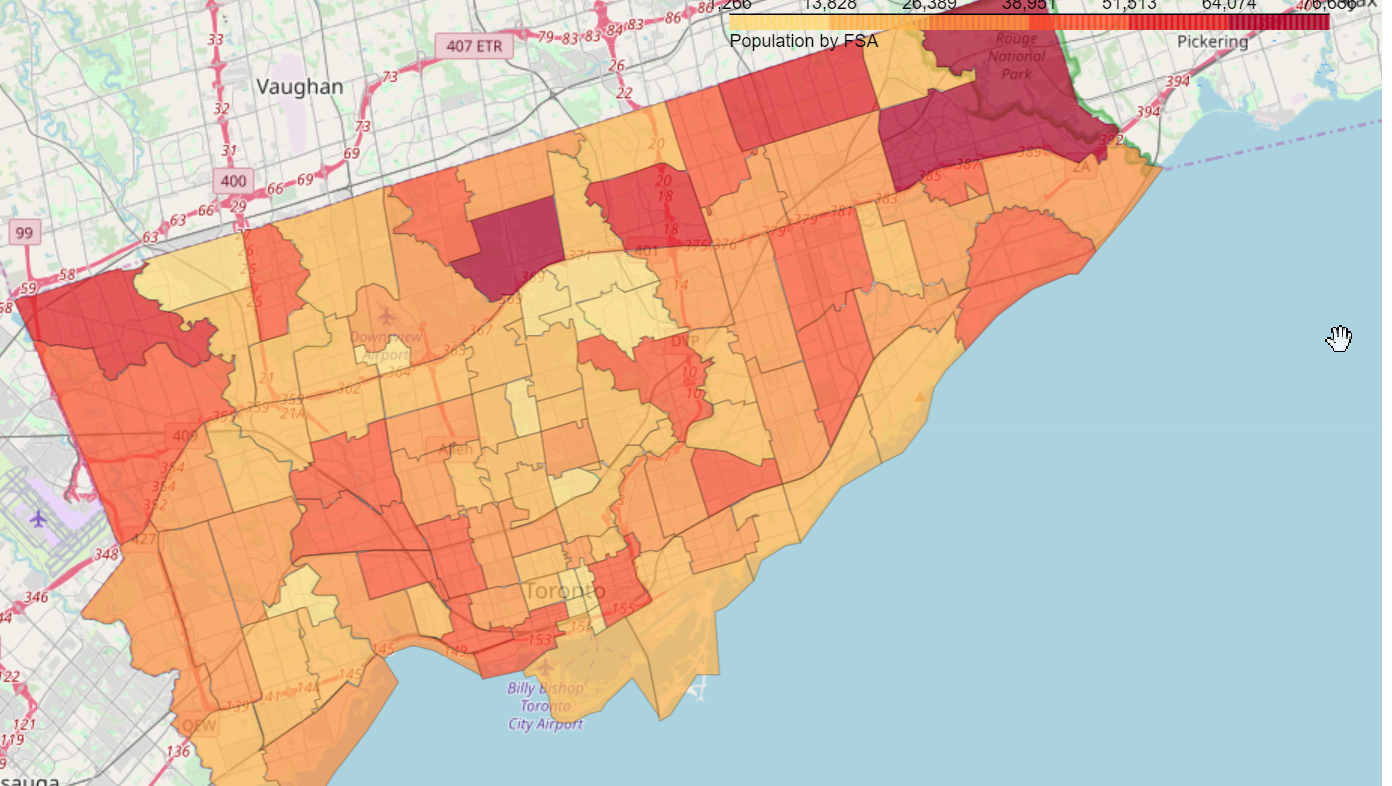

In [ ]:
# # create map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values
# map_toronto_pop = folium.Map(location=[latitude, longitude], zoom_start=10)

# toronto_geo = "./Assets/Toronto.geojson"
# map_toronto_pop.choropleth(geo_data=toronto_geo,
#     data = toronto_merged,
#     columns=['FSA','Total_2017'],
#     key_on='feature.properties.CFSAUID',
#     fill_color='YlOrRd',
#     fill_opacity=0.7, 
#     line_opacity=0.2,
#     legend_name='Total Pet Licenses 2017')   
    
# map_toronto_pop

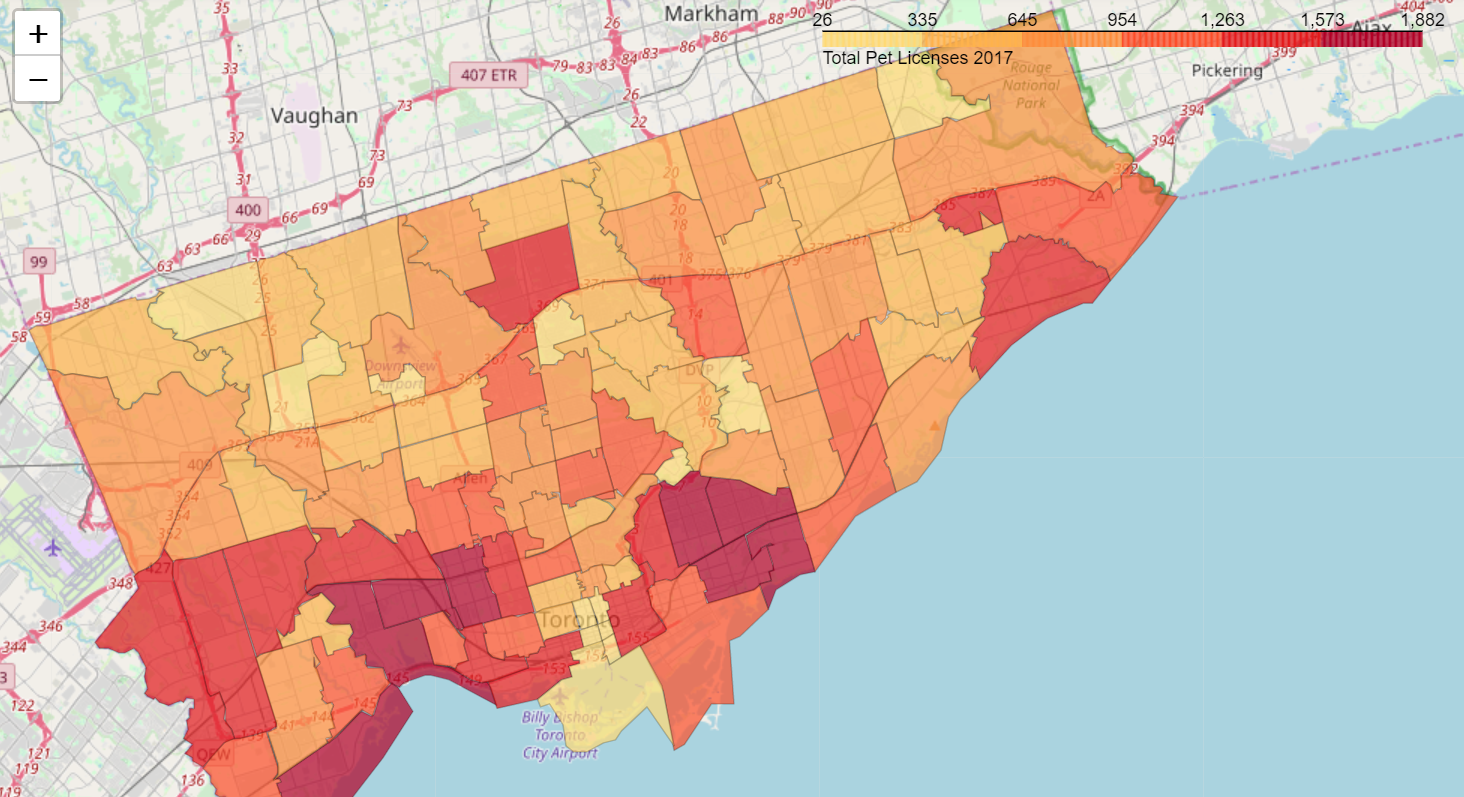

### Let's look at the change in pet ownership between 2013 and 2017


In [53]:
toronto_merged.head()

FSA       Borough                                  Neighborhood    CAT  \
14  M4C     East York                              Woodbine Heights  663.0   
88  M8V     Etobicoke  Humber Bay Shores, Mimico South, New Toronto  613.0   
47  M4L  East Toronto                The Beaches West, India Bazaar  513.0   
69  M6P  West Toronto                 High Park, The Junction South  630.0   
31  M6H  West Toronto                  Dovercourt Village, Dufferin  676.0   

       DOG  Total_2017  Total_2013      Pop   Latitude  Longitude  \
14  1201.0      1864.0      1868.0  46866.0  43.689819 -79.310364   
88  1235.0      1848.0      1603.0  37975.0  43.609921 -79.497879   
47  1315.0      1828.0      1880.0  32640.0  43.670906 -79.316269   
69  1179.0      1809.0      1663.0  40035.0  43.661224 -79.463486   
31  1085.0      1761.0      1604.0  44950.0  43.665081 -79.438728   

    PropTotal_2017  PropDogs  CatFriendly  
14            2.30     64.43            1  
88            2.28     66.83            1  
47            2.26     71.94            0  
69            2.23     65.17            1  
31            2.18     61.61            1

In [54]:
# CHange in petownership
toronto_merged['PetChange'] = toronto_merged['Total_2017']-toronto_merged['Total_2013']
toronto_merged.sort_values('PetChange',ascending=False, inplace=True)
toronto_merged.head(5)

FSA           Borough                                       Neighborhood  \
2   M5A  Downtown Toronto                          Harbourfront, Regent Park   
87  M5V  Downtown Toronto  CN Tower, Bathurst Quay, Island airport, Harbo...   
43  M6K      West Toronto       Brockton, Exhibition Place, Parkdale Village   
88  M8V         Etobicoke       Humber Bay Shores, Mimico South, New Toronto   
37  M6J      West Toronto                           Little Portugal, Trinity   

      CAT     DOG  Total_2017  Total_2013      Pop   Latitude  Longitude  \
2   416.0   949.0      1365.0       966.0  41078.0  43.655220 -79.361969   
87  353.0   987.0      1340.0       978.0  49195.0  43.640816 -79.399536   
43  427.0   876.0      1303.0      1045.0  40957.0  43.639408 -79.424026   
88  613.0  1235.0      1848.0      1603.0  37975.0  43.609921 -79.497879   
37  382.0   807.0      1189.0      1020.0  32684.0  43.648556 -79.417770   

    PropTotal_2017  PropDogs  CatFriendly  PetChange  
2             1.69     69.52            1      399.0  
87            1.66     73.66            0      362.0  
43            1.61     67.23            1      258.0  
88            2.28     66.83            1      245.0  
37            1.47     67.87            1      169.0

In [55]:
toronto_merged.tail(5)

FSA      Borough                                       Neighborhood  \
93  M8W    Etobicoke                             Alderwood, Long Branch   
17  M9C    Etobicoke  Bloordale Gardens, Eringate, Markland Wood, Ol...   
18  M1E  Scarborough                  Guildwood, Morningside, West Hill   
11  M9B    Etobicoke  Cloverdale, Islington, Martin Grove, Princess ...   
12  M1C  Scarborough             Highland Creek, Rouge Hill, Port Union   

      CAT     DOG  Total_2017  Total_2013      Pop   Latitude  Longitude  \
93  400.0   815.0      1215.0      1347.0  20674.0  43.600727 -79.539734   
17  431.0  1011.0      1442.0      1587.0  38291.0  43.648396 -79.577545   
18  467.0   963.0      1430.0      1621.0  46943.0  43.766289 -79.172890   
11  413.0   913.0      1326.0      1529.0  32400.0  43.650787 -79.550316   
12  297.0   775.0      1072.0      1354.0  35626.0  43.784672 -79.158958   

    PropTotal_2017  PropDogs  CatFriendly  PetChange  
93            1.50     67.08            1     -132.0  
17            1.78     70.11            0     -145.0  
18            1.77     67.34            1     -191.0  
11            1.64     68.85            1     -203.0  
12            1.32     72.29            0     -282.0

#### Observations on change in pet ownership
* numerically, downtown Toronto (M5A adn M5V) experienced larget pet growth (+ 399 and 362 respectively)
* this could be due to population changes (lots of condos being built downtown)
* Scarborough and Etobicoke (M1C, M9B, M1E, M9C, M8W) experienced the biggest decrease in pet licensing (-282, -203)

Next, let's also look at change in relative proportion of pet ownership from 2013 to 2017

In [56]:

toronto_merged['PropTotal_2013'] = round((toronto_merged['Total_2013']/sum(toronto_merged['Total_2013']))*100,2)
# CHange in proportion from 2013 to 2017
toronto_merged['PetChange_Prop'] = toronto_merged['PropTotal_2017']-toronto_merged['PropTotal_2013']
toronto_merged.sort_values('PetChange_Prop',ascending=False, inplace=True)
toronto_merged.head()

FSA           Borough                                       Neighborhood  \
2   M5A  Downtown Toronto                          Harbourfront, Regent Park   
87  M5V  Downtown Toronto  CN Tower, Bathurst Quay, Island airport, Harbo...   
43  M6K      West Toronto       Brockton, Exhibition Place, Parkdale Village   
88  M8V         Etobicoke       Humber Bay Shores, Mimico South, New Toronto   
99  M4Y  Downtown Toronto                               Church and Wellesley   

      CAT     DOG  Total_2017  Total_2013      Pop   Latitude  Longitude  \
2   416.0   949.0      1365.0       966.0  41078.0  43.655220 -79.361969   
87  353.0   987.0      1340.0       978.0  49195.0  43.640816 -79.399536   
43  427.0   876.0      1303.0      1045.0  40957.0  43.639408 -79.424026   
88  613.0  1235.0      1848.0      1603.0  37975.0  43.609921 -79.497879   
99  237.0   604.0       841.0       673.0  30472.0  43.666336 -79.381195   

    PropTotal_2017  PropDogs  CatFriendly  PetChange  PropTotal_2013  \
2             1.69     69.52            1      399.0            1.20   
87            1.66     73.66            0      362.0            1.21   
43            1.61     67.23            1      258.0            1.30   
88            2.28     66.83            1      245.0            1.99   
99            1.04     71.82            0      168.0            0.83   

    PetChange_Prop  
2             0.49  
87            0.45  
43            0.31  
88            0.29  
99            0.21

In [57]:
toronto_merged.tail()

FSA      Borough                                       Neighborhood  \
93  M8W    Etobicoke                             Alderwood, Long Branch   
17  M9C    Etobicoke  Bloordale Gardens, Eringate, Markland Wood, Ol...   
18  M1E  Scarborough                  Guildwood, Morningside, West Hill   
11  M9B    Etobicoke  Cloverdale, Islington, Martin Grove, Princess ...   
12  M1C  Scarborough             Highland Creek, Rouge Hill, Port Union   

      CAT     DOG  Total_2017  Total_2013      Pop   Latitude  Longitude  \
93  400.0   815.0      1215.0      1347.0  20674.0  43.600727 -79.539734   
17  431.0  1011.0      1442.0      1587.0  38291.0  43.648396 -79.577545   
18  467.0   963.0      1430.0      1621.0  46943.0  43.766289 -79.172890   
11  413.0   913.0      1326.0      1529.0  32400.0  43.650787 -79.550316   
12  297.0   775.0      1072.0      1354.0  35626.0  43.784672 -79.158958   

    PropTotal_2017  PropDogs  CatFriendly  PetChange  PropTotal_2013  \
93            1.50     67.08            1     -132.0            1.67   
17            1.78     70.11            0     -145.0            1.97   
18            1.77     67.34            1     -191.0            2.01   
11            1.64     68.85            1     -203.0            1.90   
12            1.32     72.29            0     -282.0            1.68   

    PetChange_Prop  
93           -0.17  
17           -0.19  
18           -0.24  
11           -0.26  
12           -0.36

interestingly, although Scarborough and Etobicoke have the largest proportion of pets in 2017, their proportion has decreased over the past 5 years, while the proportion of pets downtown has increased

#### Visualizations for Changes in Pet Ownership from 2013 to 2017

In [61]:
# # create map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values
# map_toronto_pop = folium.Map(location=[latitude, longitude], zoom_start=10)

# toronto_geo = "./Assets/Toronto.geojson"
# map_toronto_pop.choropleth(geo_data=toronto_geo,
#     data = toronto_merged,
#     columns=['FSA','PetChange'],
#     key_on='feature.properties.CFSAUID',
#     fill_color='YlOrRd',
#     fill_opacity=0.7, 
#     line_opacity=0.2,
#     legend_name='Change in Number of Issued Pet Licenses (2013-2017)')   
    
# map_toronto_pop

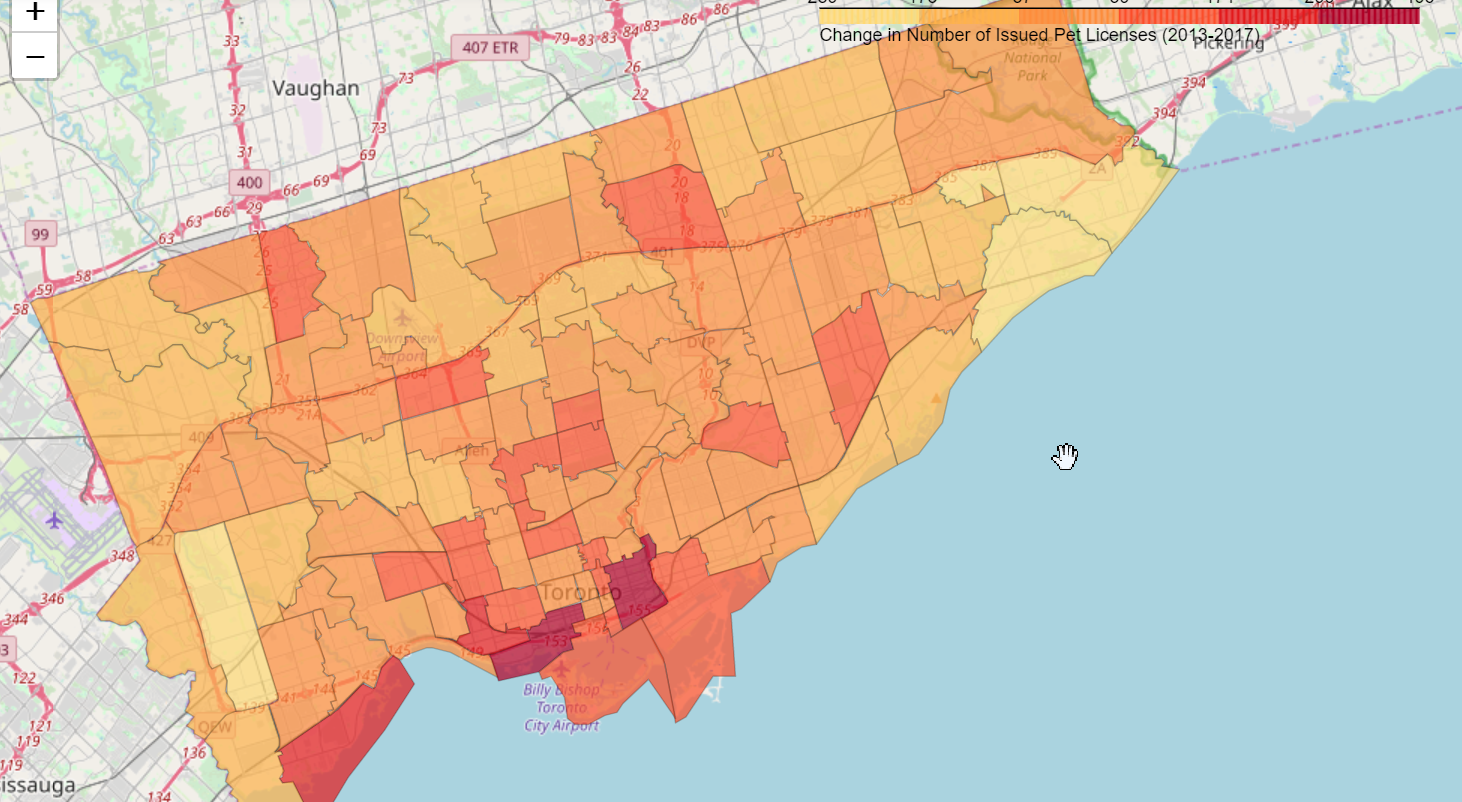

## Look at Per Capita Pet Ownership

In [62]:
# # get proportion of pets relative to population 2017
toronto_merged['PerCapitaPets']=round((toronto_merged['Total_2017']/toronto_merged['Pop']),4)
toronto_merged.reset_index()
toronto_merged.sort_values('PerCapitaPets', ascending=False,inplace=True)
toronto_merged.head()

FSA          Borough                 Neighborhood    CAT     DOG  \
19  M4E     East Toronto                  The Beaches  430.0  1181.0   
75  M6R     West Toronto       Parkdale, Roncesvalles  417.0   780.0   
93  M8W        Etobicoke       Alderwood, Long Branch  400.0   815.0   
83  M4T  Central Toronto  Moore Park, Summerhill East  114.0   493.0   
73  M4R  Central Toronto           North Toronto West  170.0   481.0   

    Total_2017  Total_2013      Pop   Latitude  Longitude  PropTotal_2017  \
19      1611.0      1582.0  25044.0  43.679611 -79.295692            1.99   
75      1197.0      1182.0  19857.0  43.648239 -79.450447            1.48   
93      1215.0      1347.0  20674.0  43.600727 -79.539734            1.50   
83       607.0       627.0  10463.0  43.690735 -79.383003            0.75   
73       651.0       620.0  11394.0  43.714615 -79.406532            0.80   

    PropDogs  CatFriendly  PetChange  PropTotal_2013  PetChange_Prop  \
19     73.31            0       29.0            1.96            0.03   
75     65.16            1       15.0            1.47            0.01   
93     67.08            1     -132.0            1.67           -0.17   
83     81.22            0      -20.0            0.78           -0.03   
73     73.89            0       31.0            0.77            0.03   

    PerCapitaPets  
19         0.0643  
75         0.0603  
93         0.0588  
83         0.0580  
73         0.0571

In [65]:
# # create map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values
# map_toronto_pop = folium.Map(location=[latitude, longitude], zoom_start=10)

# toronto_geo = "./Assets/Toronto.geojson"
# map_toronto_pop.choropleth(geo_data=toronto_geo,
#     data = toronto_merged,
#     columns=['FSA','PerCapitaPets'],
#     key_on='feature.properties.CFSAUID',
#     fill_color='YlOrRd',
#     fill_opacity=0.7, 
#     line_opacity=0.2,
#     legend_name='Per Capita Pet Licenses Issued 2017)')   
    
# map_toronto_pop

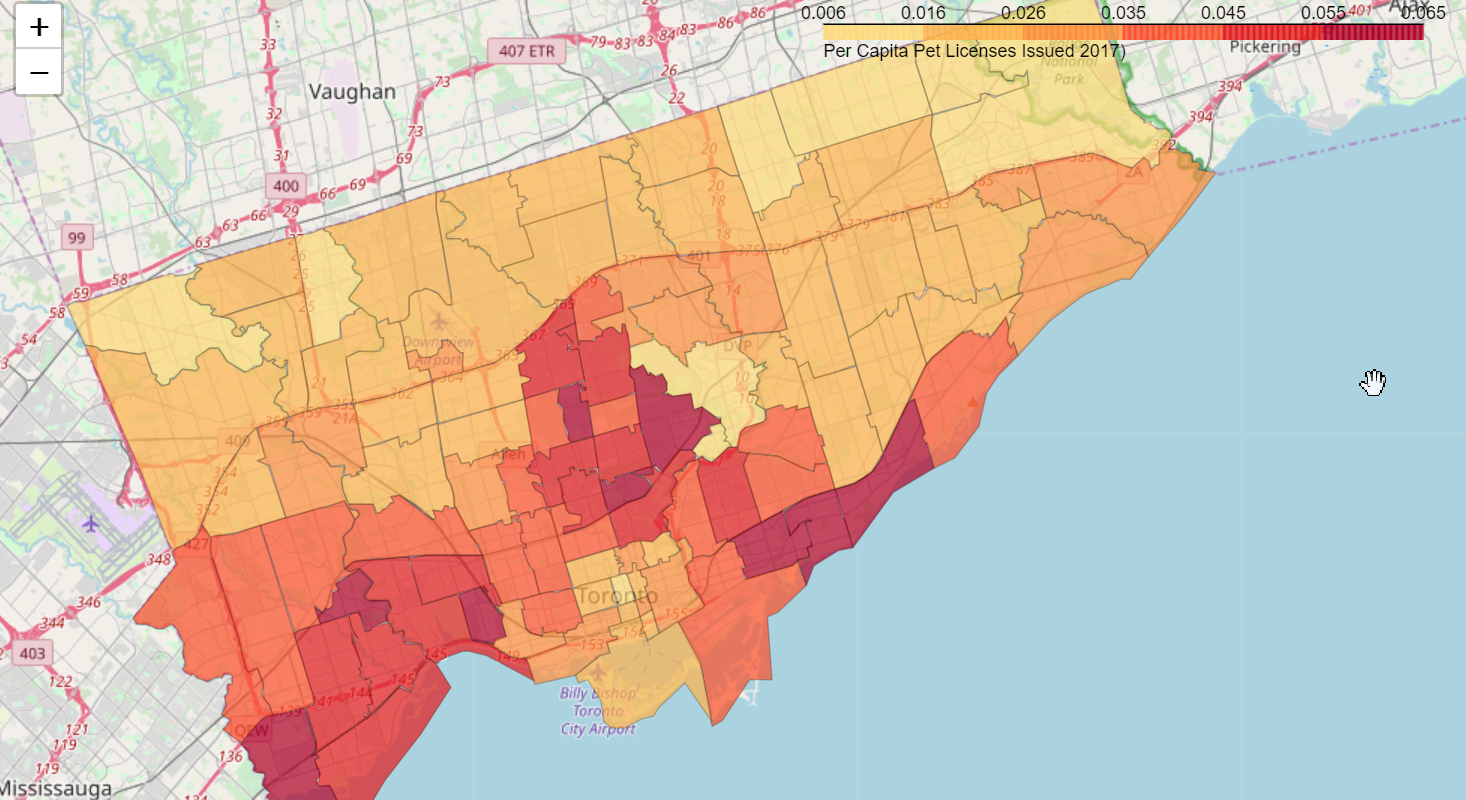

The highest per capita ownership of pets is in 
* The Beaches (M4E): 
* Parkdale/ Roncesvalles (M6R) 
* Alderwood/Long Branch(M8W)


## Now lets take a look at a higher level - the boroughs

In [66]:
merged_boroughs=toronto_merged.groupby('Borough').sum().reset_index() 

# Need to recalcualte some columsn (i.e. PerCapitaPets)
merged_boroughs["PerCapitaPets"] = merged_boroughs['Total_2017']/merged_boroughs['Pop']
merged_boroughs['PropDogs']= round((merged_boroughs['DOG']/merged_boroughs['Total_2017'])*100,2) #prop of pets in FSA that are dogs

In [67]:
# also we summed the lats and longs, which isn't correct!  so let's re-retrieve our correct coordinatoes
merged_boroughs=get_lats_longs(merged_boroughs)
merged_boroughs

Borough     CAT     DOG  Total_2017  Total_2013       Pop  \
0   Central Toronto  1717.0  5901.0      7618.0      7241.0  164502.0   
1  Downtown Toronto  2277.0  5546.0      7823.0      6493.0  271161.0   
2      East Toronto  1660.0  4251.0      5911.0      5816.0  113956.0   
3         East York  1830.0  3670.0      5500.0      5495.0  139996.0   
4         Etobicoke  3879.0  8786.0     12665.0     13186.0  365318.0   
5        North York  4208.0  9727.0     13935.0     14193.0  658944.0   
6       Scarborough  4366.0  8964.0     13330.0     14567.0  634047.0   
7      West Toronto  3048.0  5904.0      8952.0      8221.0  212782.0   
8              York  1504.0  3710.0      5214.0      5389.0  171388.0   

    Latitude  Longitude  PropTotal_2017  PropDogs  CatFriendly  PetChange  \
0  43.609450 -79.492730            9.41     77.46            0      377.0   
1  43.648689 -79.385437            9.66     70.89            6     1330.0   
2  43.628719 -79.412827            7.30     71.92            1       95.0   
3  43.691799 -79.327026            6.80     66.73            4        5.0   
4  43.644402 -79.567139           15.65     69.37            7     -521.0   
5  43.768261 -79.412628           17.19     69.80           14     -258.0   
6  43.744308 -79.232391           16.47     67.25           12    -1237.0   
7  43.629219 -79.419853           11.06     65.95            6      731.0   
8  43.692081 -79.478630            6.45     71.15            1     -175.0   

   PropTotal_2013  PetChange_Prop  PerCapitaPets  
0            8.99            0.42       0.046309  
1            8.05            1.61       0.028850  
2            7.21            0.09       0.051871  
3            6.81           -0.01       0.039287  
4           16.37           -0.72       0.034668  
5           17.61           -0.42       0.021147  
6           18.06           -1.59       0.021024  
7           10.21            0.85       0.042071  
8            6.69           -0.24       0.030422

In [68]:
print("Most Pets 2017: {}".format(merged_boroughs['Total_2017'].max()))
#merged_boroughs[(merged_boroughs['Total_2017']==merged_boroughs['Total_2017'].max())]["Borough"]
#merged_boroughs.loc[merged_boroughs['Total_2017'].idxmax()]["Borough"]
print("Most Pets 2017: {}".format(merged_boroughs.loc[merged_boroughs['Total_2017'].idxmax()]["Borough"]))
print("Most Pets 2013: {}".format(merged_boroughs.loc[merged_boroughs['Total_2013'].idxmax()]["Borough"]))
print("Highest proportion: {}".format(merged_boroughs.loc[merged_boroughs['PropTotal_2017'].idxmax()]["Borough"]))
print("Biggest change in pet proportion: {}".format(merged_boroughs.loc[merged_boroughs['PetChange_Prop'].idxmax()]["Borough"]))
print("Most per capita pets: {}".format(merged_boroughs.loc[merged_boroughs['PerCapitaPets'].idxmax()]["Borough"]))



Most Pets 2017: 13935.0
Most Pets 2017: North York
Most Pets 2013: Scarborough
Highest proportion: North York
Biggest change in pet proportion: Downtown Toronto
Most per capita pets: East Toronto


In [69]:
merged_boroughs.sort_values('Total_2017', ascending=False)

Borough     CAT     DOG  Total_2017  Total_2013       Pop  \
5        North York  4208.0  9727.0     13935.0     14193.0  658944.0   
6       Scarborough  4366.0  8964.0     13330.0     14567.0  634047.0   
4         Etobicoke  3879.0  8786.0     12665.0     13186.0  365318.0   
7      West Toronto  3048.0  5904.0      8952.0      8221.0  212782.0   
1  Downtown Toronto  2277.0  5546.0      7823.0      6493.0  271161.0   
0   Central Toronto  1717.0  5901.0      7618.0      7241.0  164502.0   
2      East Toronto  1660.0  4251.0      5911.0      5816.0  113956.0   
3         East York  1830.0  3670.0      5500.0      5495.0  139996.0   
8              York  1504.0  3710.0      5214.0      5389.0  171388.0   

    Latitude  Longitude  PropTotal_2017  PropDogs  CatFriendly  PetChange  \
5  43.768261 -79.412628           17.19     69.80           14     -258.0   
6  43.744308 -79.232391           16.47     67.25           12    -1237.0   
4  43.644402 -79.567139           15.65     69.37            7     -521.0   
7  43.629219 -79.419853           11.06     65.95            6      731.0   
1  43.648689 -79.385437            9.66     70.89            6     1330.0   
0  43.609450 -79.492730            9.41     77.46            0      377.0   
2  43.628719 -79.412827            7.30     71.92            1       95.0   
3  43.691799 -79.327026            6.80     66.73            4        5.0   
8  43.692081 -79.478630            6.45     71.15            1     -175.0   

   PropTotal_2013  PetChange_Prop  PerCapitaPets  
5           17.61           -0.42       0.021147  
6           18.06           -1.59       0.021024  
4           16.37           -0.72       0.034668  
7           10.21            0.85       0.042071  
1            8.05            1.61       0.028850  
0            8.99            0.42       0.046309  
2            7.21            0.09       0.051871  
3            6.81           -0.01       0.039287  
8            6.69           -0.24       0.030422

In [70]:
merged_boroughs.sort_values('PerCapitaPets',inplace=True, ascending=False)
merged_boroughs


Borough     CAT     DOG  Total_2017  Total_2013       Pop  \
2      East Toronto  1660.0  4251.0      5911.0      5816.0  113956.0   
0   Central Toronto  1717.0  5901.0      7618.0      7241.0  164502.0   
7      West Toronto  3048.0  5904.0      8952.0      8221.0  212782.0   
3         East York  1830.0  3670.0      5500.0      5495.0  139996.0   
4         Etobicoke  3879.0  8786.0     12665.0     13186.0  365318.0   
8              York  1504.0  3710.0      5214.0      5389.0  171388.0   
1  Downtown Toronto  2277.0  5546.0      7823.0      6493.0  271161.0   
5        North York  4208.0  9727.0     13935.0     14193.0  658944.0   
6       Scarborough  4366.0  8964.0     13330.0     14567.0  634047.0   

    Latitude  Longitude  PropTotal_2017  PropDogs  CatFriendly  PetChange  \
2  43.628719 -79.412827            7.30     71.92            1       95.0   
0  43.609450 -79.492730            9.41     77.46            0      377.0   
7  43.629219 -79.419853           11.06     65.95            6      731.0   
3  43.691799 -79.327026            6.80     66.73            4        5.0   
4  43.644402 -79.567139           15.65     69.37            7     -521.0   
8  43.692081 -79.478630            6.45     71.15            1     -175.0   
1  43.648689 -79.385437            9.66     70.89            6     1330.0   
5  43.768261 -79.412628           17.19     69.80           14     -258.0   
6  43.744308 -79.232391           16.47     67.25           12    -1237.0   

   PropTotal_2013  PetChange_Prop  PerCapitaPets  
2            7.21            0.09       0.051871  
0            8.99            0.42       0.046309  
7           10.21            0.85       0.042071  
3            6.81           -0.01       0.039287  
4           16.37           -0.72       0.034668  
8            6.69           -0.24       0.030422  
1            8.05            1.61       0.028850  
5           17.61           -0.42       0.021147  
6           18.06           -1.59       0.021024

Interestingly, even though areas like East Toronto have a low proportion of the pets in Toronto, they ahve the highest per capita 

### Now create a map showing Pets Per Capita in the Different Boroughs

In [71]:
# create map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values
# show Pets per Capita per area
map_toronto_boroughs = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, total in zip(merged_boroughs['Latitude'], merged_boroughs['Longitude'],  merged_boroughs['Borough'],merged_boroughs['PerCapitaPets']):
    label = '{} (Pets per Capita {})'.format(neighborhood, total)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=total*400,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto_boroughs)
    
map_toronto_boroughs


In [73]:
# #legend=alt.Legend(title='Clusters')
# cluster_chart = alt.Chart(merged_boroughs).mark_point(filled=True, size=200).encode(
#     x=alt.X('Total_2017', axis=alt.Axis(title='New Licenses 2017')),
#     y=alt.Y('Total_2013', axis=alt.Axis(title='New Licenses 2013')),
#     size=alt.Size('Pop',legend=alt.Legend(title='Population')),
#     color=alt.Color('Borough:O',scale=alt.Scale(scheme='category10'),legend=alt.Legend(title='Clusters')),
#     tooltip=['Borough', 'Pop','Total_2017']
# ).properties(title="Toronto Boroughs")

# # text = cluster_chart.mark_text(
# #     align='left',
# #     dx=5,
# #     size=12
# # ).encode(
# #     text='Borough'
# # )

# cluster_chart#+text

In [74]:
merged_boroughs.head()

Borough     CAT     DOG  Total_2017  Total_2013       Pop  \
2     East Toronto  1660.0  4251.0      5911.0      5816.0  113956.0   
0  Central Toronto  1717.0  5901.0      7618.0      7241.0  164502.0   
7     West Toronto  3048.0  5904.0      8952.0      8221.0  212782.0   
3        East York  1830.0  3670.0      5500.0      5495.0  139996.0   
4        Etobicoke  3879.0  8786.0     12665.0     13186.0  365318.0   

    Latitude  Longitude  PropTotal_2017  PropDogs  CatFriendly  PetChange  \
2  43.628719 -79.412827            7.30     71.92            1       95.0   
0  43.609450 -79.492730            9.41     77.46            0      377.0   
7  43.629219 -79.419853           11.06     65.95            6      731.0   
3  43.691799 -79.327026            6.80     66.73            4        5.0   
4  43.644402 -79.567139           15.65     69.37            7     -521.0   

   PropTotal_2013  PetChange_Prop  PerCapitaPets  
2            7.21            0.09       0.051871  
0            8.99            0.42       0.046309  
7           10.21            0.85       0.042071  
3            6.81           -0.01       0.039287  
4           16.37           -0.72       0.034668

# Now call foursquare for each neighborhood to get the list of pet stores and services in each FSA

In [75]:
# The code was removed by Watson Studio for sharing.

Your credentails are hidden:


In [76]:
# let's borrow this function from the lab to extract the venue type
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [77]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    '''Call FourSquare api to retrieve nearby Pet Stores and Pet services'''
    
    venues_list=[]
    categoryID='4bf58dd8d48988d100951735,5032897c91d4c4b30a586d69' # pet services and petstore
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryID)
        #print(requests.get(url).json())
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print('Your quota may have been exceeded')
            return
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

* Call the getNearbyVenues function for each FSA to get the nearby pet services
* stuff our results in a new dataframe, toronto_venues
* Note on Radius used
    * FourSquare lets you designate how far around the specified coordinates you want to look for a venue
    * trade off: as increase the distance, you increase the  number of overlaps (venues that are counted as being in more than one FSA).  This is particularly true for smaller downtown FSAs.  But if you make the radius too small, then you are likley excluding venues in the larger, suburban FSAs
    * 1 KM / 1000 m seems to be a good tradeoff.  It results in a lot more overlaps, but 1 km is a walkable distance downtown

In [79]:
LIMIT=100
radius = 1000

# work around due to foursquare api limitations
if offline==True:
    toronto_venues = pd.read_csv("./Assets/toronto_venues.csv")
else:
    #get fresh data
    toronto_venues = getNearbyVenues(names=toronto_merged['Neighborhood'],latitudes=toronto_merged['Latitude'],longitudes=toronto_merged['Longitude'],radius=radius)

The Beaches
Parkdale, Roncesvalles
Alderwood, Long Branch
Moore Park, Summerhill East
North Toronto West
Leaside
Birch Cliff, Cliffside West
The Beaches West, India Bazaar
The Kingsway, Montgomery Road, Old Mill North
Lawrence Park
Kingsway Park South West, Mimico NW, The Queensway West, Royal York South West, South of Bloor
Rosedale
Runnymede, Swansea
Forest Hill North, Forest Hill West
Humber Bay Shores, Mimico South, New Toronto
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Bedford Park, Lawrence Manor East
East Toronto
Humber Bay, King's Mill Park, Kingsway Park South East, Mimico NE, Old Mill South, The Queensway East, Royal York South East, Sunnylea
Davisville
High Park, The Junction South
The Danforth West, Riverdale
Studio District
Davisville North
York Mills West
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Woodbine Gardens, Parkview Hill
Woodbine Heights
Christie
Roselawn
Dovercourt Village, Dufferin
Humewood-Cedarvale
Cliffcrest,

In [80]:
toronto_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0             The Beaches              43.679611              -79.295692   
1             The Beaches              43.679611              -79.295692   
2             The Beaches              43.679611              -79.295692   
3  Parkdale, Roncesvalles              43.648239              -79.450447   
4  Parkdale, Roncesvalles              43.648239              -79.450447   

            Venue  Venue Latitude  Venue Longitude Venue Category  
0           Tails       43.670762       -79.296424      Pet Store  
1  The Dog Market       43.671163       -79.294773      Pet Store  
2        Pet Valu       43.672517       -79.288923      Pet Store  
3     Kennel Cafe       43.647860       -79.449777      Pet Store  
4           Fetch       43.650127       -79.450548      Pet Store

In [82]:
# temp save this to a spreadsheet so can test offline
# toronto_venues.to_csv("./Assets/toronto_venues_1000.csv", index=False)


In [83]:
toronto_venues.shape 

(188, 7)

In [84]:
toronto_venues["Venue Category"].value_counts()

Pet Store       126
Pet Service      58
Veterinarian      4
Name: Venue Category, dtype: int64

### Now merge this retrieved venues info with our toronto_merged dataframe

* Note: not every FSA will have a venue so need to do a left outer join so we don't lose the FSAs without any venues
* we're also going to end up with duplicated Latitude / Neighbourhood Latitude and longitude/ Neighbourhood longitude columns -- we could drop the duplicates, but didn't in this case

In [90]:
toronto_venues_merged = toronto_merged.set_index('Neighborhood').reset_index()
toronto_venues_merged.head()

Neighborhood  FSA          Borough    CAT     DOG  \
0                  The Beaches  M4E     East Toronto  430.0  1181.0   
1       Parkdale, Roncesvalles  M6R     West Toronto  417.0   780.0   
2       Alderwood, Long Branch  M8W        Etobicoke  400.0   815.0   
3  Moore Park, Summerhill East  M4T  Central Toronto  114.0   493.0   
4           North Toronto West  M4R  Central Toronto  170.0   481.0   

   Total_2017  Total_2013      Pop   Latitude  Longitude  PropTotal_2017  \
0      1611.0      1582.0  25044.0  43.679611 -79.295692            1.99   
1      1197.0      1182.0  19857.0  43.648239 -79.450447            1.48   
2      1215.0      1347.0  20674.0  43.600727 -79.539734            1.50   
3       607.0       627.0  10463.0  43.690735 -79.383003            0.75   
4       651.0       620.0  11394.0  43.714615 -79.406532            0.80   

   PropDogs  CatFriendly  PetChange  PropTotal_2013  PetChange_Prop  \
0     73.31            0       29.0            1.96            0.03   
1     65.16            1       15.0            1.47            0.01   
2     67.08            1     -132.0            1.67           -0.17   
3     81.22            0      -20.0            0.78           -0.03   
4     73.89            0       31.0            0.77            0.03   

   PerCapitaPets  
0         0.0643  
1         0.0603  
2         0.0588  
3         0.0580  
4         0.0571

In [91]:
#toronto_venues_merged = toronto_merged.set_index('Neighborhood')
toronto_venues_merged = toronto_venues_merged.merge(right=toronto_venues, how='outer', on='Neighborhood')
toronto_venues_merged.head()


Neighborhood  FSA       Borough    CAT     DOG  Total_2017  \
0             The Beaches  M4E  East Toronto  430.0  1181.0      1611.0   
1             The Beaches  M4E  East Toronto  430.0  1181.0      1611.0   
2             The Beaches  M4E  East Toronto  430.0  1181.0      1611.0   
3  Parkdale, Roncesvalles  M6R  West Toronto  417.0   780.0      1197.0   
4  Parkdale, Roncesvalles  M6R  West Toronto  417.0   780.0      1197.0   

   Total_2013      Pop   Latitude  Longitude      ...        PetChange  \
0      1582.0  25044.0  43.679611 -79.295692      ...             29.0   
1      1582.0  25044.0  43.679611 -79.295692      ...             29.0   
2      1582.0  25044.0  43.679611 -79.295692      ...             29.0   
3      1182.0  19857.0  43.648239 -79.450447      ...             15.0   
4      1182.0  19857.0  43.648239 -79.450447      ...             15.0   

   PropTotal_2013  PetChange_Prop  PerCapitaPets  Neighborhood Latitude  \
0            1.96            0.03         0.0643              43.679611   
1            1.96            0.03         0.0643              43.679611   
2            1.96            0.03         0.0643              43.679611   
3            1.47            0.01         0.0603              43.648239   
4            1.47            0.01         0.0603              43.648239   

   Neighborhood Longitude           Venue  Venue Latitude  Venue Longitude  \
0              -79.295692           Tails       43.670762       -79.296424   
1              -79.295692  The Dog Market       43.671163       -79.294773   
2              -79.295692        Pet Valu       43.672517       -79.288923   
3              -79.450447     Kennel Cafe       43.647860       -79.449777   
4              -79.450447           Fetch       43.650127       -79.450548   

  Venue Category  
0      Pet Store  
1      Pet Store  
2      Pet Store  
3      Pet Store  
4      Pet Store  

[5 rows x 23 columns]

In [92]:
toronto_venues_merged.shape


(218, 23)

Are there any duplicate restaurants being counted in two neighborhoods?

* it turns out we have two shops being counted twice, but this doesn't seem alarming so will not make any changes
* Our FourSquare api is looking for venues within 400m of the FSA lat/long coordinates, so it makes sense that we could end up with some overlap in areas where the FSAs are small
* If a venue is within 400m of an FSA, then it makes sense to count it in that FSA even if it is also in another FSA -- for our purposes, we're interested in nearby services

In [93]:
# are there any duplicate restaurants being counted in two neighborhoods?
df = toronto_venues_merged[toronto_venues_merged.duplicated(subset=['Venue','Venue Latitude','Venue Longitude'], keep=False)]
df.sort_values(by=['Venue'],inplace=True,ascending=False)
df=df.dropna()
print('There are {} services/shops counted as being in more than 1 neighborhood'.format(len(df)))
# however, maybe there is no need to clean this up, since what we're really concerned about is nearby ammenities

There are 59 services/shops counted as being in more than 1 neighborhood


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [94]:
toronto_venues_merged["Venue Category"].value_counts()

Pet Store       126
Pet Service      58
Veterinarian      4
Name: Venue Category, dtype: int64

In [95]:
toronto_merged.shape
# 96 FSAs to start with

(96, 17)

### Special handling for FSAs with no venues

* When we do the groupby / sum operation below, we're losing FSAs that have no venues.  
* so let's create a dataframe with just those FSAs that have no venues that we can add back in later
* clean up the columns in the dataframe to match the dataframe we'll eventually be merging into
* set venue count to 0

In [96]:

# store the FSAs missing Venues
fsa_no_venues =toronto_venues_merged[(toronto_venues_merged['Venue'].isna())]
fsa_no_venues.shape

(30, 23)

In [97]:
fsa_no_venues = fsa_no_venues[['FSA','Borough','Neighborhood','Pop','Total_2017', 'PropTotal_2017', 'PerCapitaPets','Latitude','Longitude']]
fsa_no_venues['Venue'] = 0
fsa_no_venues.rename(columns={'Latitude': 'Neighborhood Latitude','Longitude': 'Neighborhood Longitude'}, inplace=True)
 
fsa_no_venues.head()

FSA           Borough                                       Neighborhood  \
7   M8W         Etobicoke                             Alderwood, Long Branch   
25  M4N   Central Toronto                                      Lawrence Park   
27  M4W  Downtown Toronto                                           Rosedale   
76  M2P        North York                                    York Mills West   
77  M9B         Etobicoke  Cloverdale, Islington, Martin Grove, Princess ...   

        Pop  Total_2017  PropTotal_2017  PerCapitaPets  Neighborhood Latitude  \
7   20674.0      1215.0            1.50         0.0588              43.600727   
25  15330.0       841.0            1.04         0.0549              43.728504   
27  14561.0       740.0            0.91         0.0508              43.682049   
76   7843.0       325.0            0.40         0.0414              43.749180   
77  32400.0      1326.0            1.64         0.0409              43.650787   

    Neighborhood Longitude  Venue  
7               -79.539734      0  
25              -79.388443      0  
27              -79.378189      0  
76              -79.399178      0  
77              -79.550316      0

### Now count venues in each neighbourhood

In [99]:

toronto_counts = toronto_venues_merged[['FSA','Borough','Neighborhood', 'Pop','Total_2017', 'PropTotal_2017', 'PerCapitaPets', 'Neighborhood Latitude','Neighborhood Longitude','Venue Category','Venue']].groupby(['FSA','Borough','Neighborhood','Pop','Total_2017', 'PropTotal_2017', 'PerCapitaPets','Neighborhood Latitude','Neighborhood Longitude','Venue Category'], as_index=False).count()
toronto_counts.head(10)

FSA      Borough                                       Neighborhood  \
0  M1B  Scarborough                                     Rouge, Malvern   
1  M1C  Scarborough             Highland Creek, Rouge Hill, Port Union   
2  M1E  Scarborough                  Guildwood, Morningside, West Hill   
3  M1K  Scarborough        East Birchmount Park, Ionview, Kennedy Park   
4  M1K  Scarborough        East Birchmount Park, Ionview, Kennedy Park   
5  M1M  Scarborough    Cliffcrest, Cliffside, Scarborough Village West   
6  M1N  Scarborough                        Birch Cliff, Cliffside West   
7  M1P  Scarborough  Dorset Park, Scarborough Town Centre, Wexford ...   
8  M1S  Scarborough                                          Agincourt   
9  M1T  Scarborough            Clarks Corners, Sullivan, Tam O'Shanter   

       Pop  Total_2017  PropTotal_2017  PerCapitaPets  Neighborhood Latitude  \
0  66108.0       912.0            1.13         0.0138              43.810154   
1  35626.0      1072.0            1.32         0.0301              43.784672   
2  46943.0      1430.0            1.77         0.0305              43.766289   
3  48434.0      1107.0            1.37         0.0229              43.725803   
4  48434.0      1107.0            1.37         0.0229              43.725803   
5  22913.0       877.0            1.08         0.0383              43.723576   
6  22136.0      1245.0            1.54         0.0562              43.697884   
7  45571.0       798.0            0.99         0.0175              43.759884   
8  37769.0       615.0            0.76         0.0163              43.797707   
9  34588.0       590.0            0.73         0.0171              43.785000   

   Neighborhood Longitude Venue Category  Venue  
0              -79.194603      Pet Store      2  
1              -79.158958    Pet Service      1  
2              -79.172890    Pet Service      2  
3              -79.262848    Pet Service      1  
4              -79.262848      Pet Store      1  
5              -79.234451    Pet Service      1  
6              -79.258759      Pet Store      1  
7              -79.268333      Pet Store      1  
8              -79.267708      Pet Store      1  
9              -79.299355      Pet Store      1

In [100]:
toronto_counts.shape

(102, 11)

In [101]:
## Let's get a count of total Pet services/stores for each neighborhood (regardless of FourSquare category)
toronto_total_pet_services = pd.DataFrame(toronto_counts.groupby(['FSA','Borough','Neighborhood','Pop','Total_2017', 'PropTotal_2017', 'PerCapitaPets','Neighborhood Latitude','Neighborhood Longitude'])['Venue'].agg('sum'))
toronto_total_pet_services.reset_index(inplace=True)
toronto_total_pet_services.head()



FSA      Borough                                     Neighborhood      Pop  \
0  M1B  Scarborough                                   Rouge, Malvern  66108.0   
1  M1C  Scarborough           Highland Creek, Rouge Hill, Port Union  35626.0   
2  M1E  Scarborough                Guildwood, Morningside, West Hill  46943.0   
3  M1K  Scarborough      East Birchmount Park, Ionview, Kennedy Park  48434.0   
4  M1M  Scarborough  Cliffcrest, Cliffside, Scarborough Village West  22913.0   

   Total_2017  PropTotal_2017  PerCapitaPets  Neighborhood Latitude  \
0       912.0            1.13         0.0138              43.810154   
1      1072.0            1.32         0.0301              43.784672   
2      1430.0            1.77         0.0305              43.766289   
3      1107.0            1.37         0.0229              43.725803   
4       877.0            1.08         0.0383              43.723576   

   Neighborhood Longitude  Venue  
0              -79.194603      2  
1              -79.158958      1  
2              -79.172890      2  
3              -79.262848      2  
4              -79.234451      1

In [102]:
toronto_total_pet_services.shape

(66, 10)

## Merge our two dataframes back together 

* now we will have one dataframe that contains FSAs both with and without services
* confirm that we are back to 96 FSAs

In [103]:
# merge back in our neighbourhoods that are missing pet stores

toronto_total_pet_services = pd.concat([fsa_no_venues,toronto_total_pet_services], axis=0)
toronto_total_pet_services.shape

(96, 10)

### Create a Choropleth map showing the  number of venues in each FSA

In [ ]:
# # create map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values
# map_toronto_pop = folium.Map(location=[latitude, longitude], zoom_start=10)

# toronto_geo = "./Assets/Toronto.geojson"
# map_toronto_pop.choropleth(geo_data=toronto_geo,
#     data = toronto_total_pet_services,
#     columns=['FSA','Venue'],
#     key_on='feature.properties.CFSAUID',
#     fill_color='YlOrRd',
#     fill_opacity=0.7, 
#     line_opacity=0.2,
#     legend_name='Number of Pet Stores/Services')   
    
# map_toronto_pop

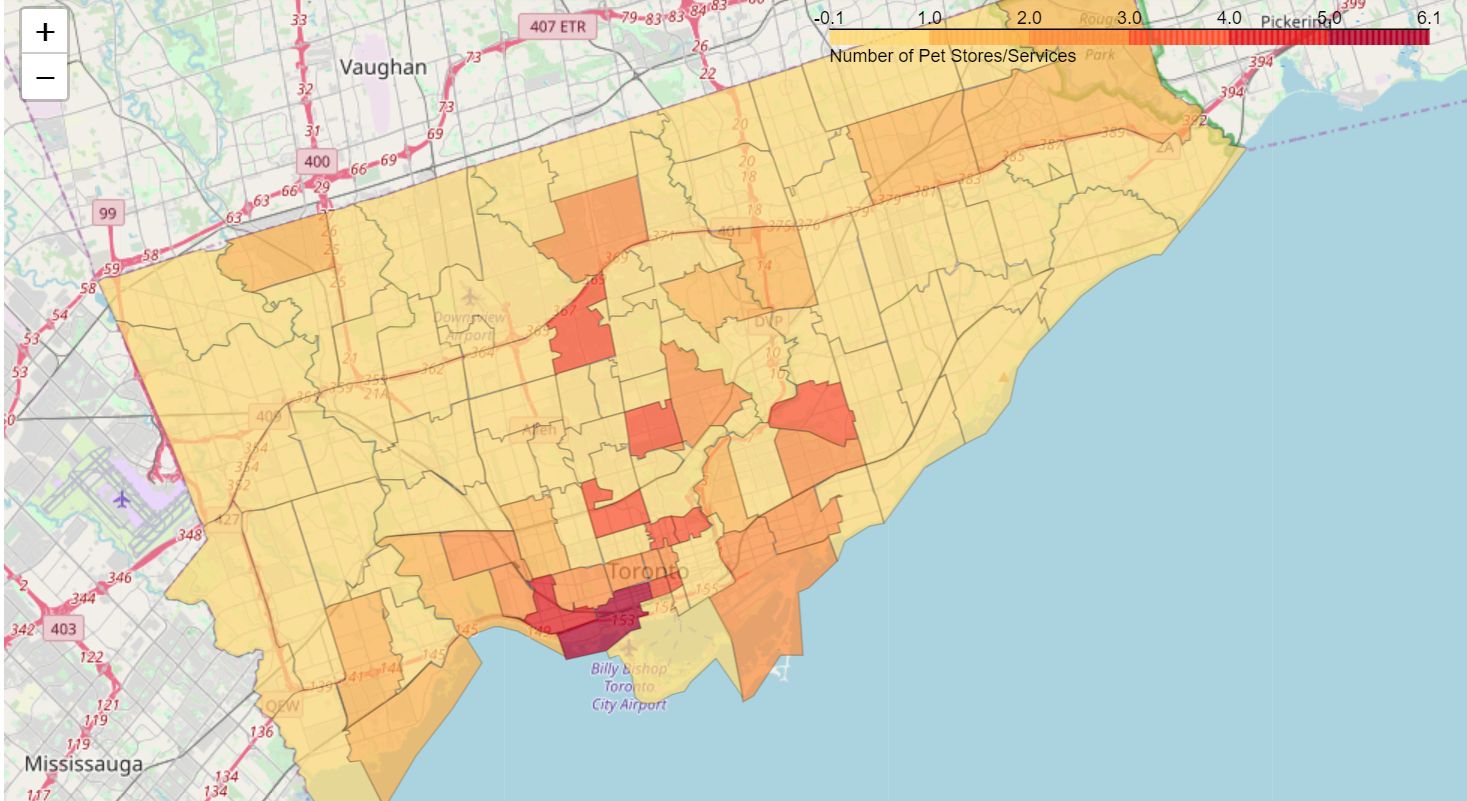

### Find areas underserved by pet store services/venues

In [104]:
toronto_total_pet_services['PetServicesPerPerCapitaPet'] = toronto_total_pet_services['Venue']/toronto_total_pet_services['PerCapitaPets']
toronto_total_pet_services.sort_values(by='PetServicesPerPerCapitaPet', ascending=True, inplace=True)
toronto_total_pet_services.head()

FSA      Borough                                       Neighborhood  \
7    M8W    Etobicoke                             Alderwood, Long Branch   
215  M1X  Scarborough                                        Upper Rouge   
214  M3N   North York                                Downsview Northwest   
212  M9V    Etobicoke  Albion Gardens, Beaumond Heights, Humbergate, ...   
211  M1W  Scarborough                      L'Amoreaux West, Steeles West   

         Pop  Total_2017  PropTotal_2017  PerCapitaPets  \
7    20674.0      1215.0            1.50         0.0588   
215  15097.0       148.0            0.18         0.0098   
214  41958.0       466.0            0.58         0.0111   
212  55959.0       636.0            0.79         0.0114   
211  48471.0       670.0            0.83         0.0138   

     Neighborhood Latitude  Neighborhood Longitude  Venue  \
7                43.600727              -79.539734      0   
215              43.834435              -79.218910      0   
214              43.756931              -79.519714      0   
212              43.742935              -79.584831      0   
211              43.801563              -79.318871      0   

     PetServicesPerPerCapitaPet  
7                           0.0  
215                         0.0  
214                         0.0  
212                         0.0  
211                         0.0

### Since the population and counts are on different scales, they should be scaled before doing any analysis
* will use StandardScaler from SciKitlearn
* Get a subset of our features and store in X_train.  Let's try to cluster based on:

    * Population
    * Total Pets in 2017
    * Number of existing venues

In [105]:
X_train = toronto_total_pet_services[['Pop', 'Total_2017', 'Venue']].copy() 

In [106]:
scaler = StandardScaler()
X_train[['Pop', 'Total_2017', 'Venue']] = scaler.fit_transform(X_train[['Pop', 'Total_2017', 'Venue']])
X_train.head()

Pop  Total_2017     Venue
7   -0.558694    0.812194 -0.997744
215 -0.958914   -1.518712 -0.997744
214  0.968701   -0.824027 -0.997744
212  1.973449   -0.452655 -0.997744
211  1.436091   -0.378381 -0.997744

VIsualize these relationships before plotting

In [115]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [116]:
alt.Chart(X_train).mark_point(filled=True, size=200).encode(
    x=alt.X('Pop', axis=alt.Axis(title='Population')),
    y=alt.Y('Total_2017', axis=alt.Axis(title='Total Licenses 2017')),
).properties(title="Number of licenses issued tends to increase as population increases")


Generally as population increases, total pets increase.  These values have a moderate positive correlation (p score=.55)

In [110]:
#plt.scatter( X_train['Total_2017'],X_train['Venue'])
cluster_chart = alt.Chart(X_train).mark_point(filled=True, size=200).encode(
    x=alt.X('Total_2017', axis=alt.Axis(title='Total Licenses 2017')),
    y=alt.Y('Venue', axis=alt.Axis(title='Num Venues')),
).properties(title="Relationship between Licenses Issued and Number of Venues")
cluster_chart

relationship is less clear here... can see some areas with large number of pets but very few services

In [111]:
X_train.corr()

Pop  Total_2017     Venue
Pop         1.000000    0.554520  0.003974
Total_2017  0.554520    1.000000  0.360886
Venue       0.003974    0.360886  1.000000

### Clustering


First step is to determine how many clusters we should divide the neighbourhoods into.  Let's use the visual Elbow method

We'll loop through using 1 to 20 clusters and get the scores in a list

In [117]:

num_clusters = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in num_clusters]

score = [kmeans[i].fit(X_train).score(X_train) for i in range(len(kmeans))]
#score

In [119]:

# i = 1
# for s in score:
#     print(score[i]-score[i-1])
#     i+=1

Next, plot the score vs the number of clusters and look for the "elbow" where you get diminishing returns

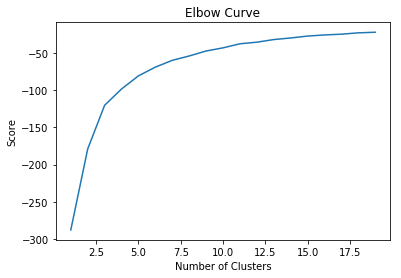

In [120]:
plt.plot(num_clusters, score)
plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.title('Elbow Curve')

plt.show()

Looks like the elbow is at 12 clusters, so let's use that and re-run KMeans to get our Clusters

In [122]:
# set number of clusters
kclusters = 12

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X_train)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[20:30] 

array([9, 8, 3, 8, 3, 4, 2, 2, 4, 9], dtype=int32)

* add clustering labels back to our original data set

In [123]:
# # add clustering labels back to our original data set
toronto_total_pet_services['Cluster Labels'] = kmeans.labels_

toronto_total_pet_services.head()

FSA      Borough                                       Neighborhood  \
7    M8W    Etobicoke                             Alderwood, Long Branch   
215  M1X  Scarborough                                        Upper Rouge   
214  M3N   North York                                Downsview Northwest   
212  M9V    Etobicoke  Albion Gardens, Beaumond Heights, Humbergate, ...   
211  M1W  Scarborough                      L'Amoreaux West, Steeles West   

         Pop  Total_2017  PropTotal_2017  PerCapitaPets  \
7    20674.0      1215.0            1.50         0.0588   
215  15097.0       148.0            0.18         0.0098   
214  41958.0       466.0            0.58         0.0111   
212  55959.0       636.0            0.79         0.0114   
211  48471.0       670.0            0.83         0.0138   

     Neighborhood Latitude  Neighborhood Longitude  Venue  \
7                43.600727              -79.539734      0   
215              43.834435              -79.218910      0   
214              43.756931              -79.519714      0   
212              43.742935              -79.584831      0   
211              43.801563              -79.318871      0   

     PetServicesPerPerCapitaPet  Cluster Labels  
7                           0.0               8  
215                         0.0               3  
214                         0.0               2  
212                         0.0               7  
211                         0.0               2

Add 2013 totals back into dataframe for charting

In [124]:
toronto_total_pet_services = toronto_total_pet_services.merge(toronto_merged[['FSA','Total_2013']],on='FSA')
toronto_total_pet_services.head()

FSA      Borough                                       Neighborhood  \
0  M8W    Etobicoke                             Alderwood, Long Branch   
1  M1X  Scarborough                                        Upper Rouge   
2  M3N   North York                                Downsview Northwest   
3  M9V    Etobicoke  Albion Gardens, Beaumond Heights, Humbergate, ...   
4  M1W  Scarborough                      L'Amoreaux West, Steeles West   

       Pop  Total_2017  PropTotal_2017  PerCapitaPets  Neighborhood Latitude  \
0  20674.0      1215.0            1.50         0.0588              43.600727   
1  15097.0       148.0            0.18         0.0098              43.834435   
2  41958.0       466.0            0.58         0.0111              43.756931   
3  55959.0       636.0            0.79         0.0114              43.742935   
4  48471.0       670.0            0.83         0.0138              43.801563   

   Neighborhood Longitude  Venue  PetServicesPerPerCapitaPet  Cluster Labels  \
0              -79.539734      0                         0.0               8   
1              -79.218910      0                         0.0               3   
2              -79.519714      0                         0.0               2   
3              -79.584831      0                         0.0               7   
4              -79.318871      0                         0.0               2   

   Total_2013  
0      1347.0  
1       161.0  
2       366.0  
3       732.0  
4       736.0

In [125]:
# create map to visualize the clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_total_pet_services['Neighborhood Latitude'], toronto_total_pet_services['Neighborhood Longitude'], toronto_total_pet_services['Neighborhood'], toronto_total_pet_services['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

For simplicity, let's replot just our three clusters of interest

In [126]:
# create map to visualize the clusters
clusters_of_interest = toronto_total_pet_services[(toronto_total_pet_services['Cluster Labels'] ==4) | (toronto_total_pet_services['Cluster Labels'] == 2) | (toronto_total_pet_services['Cluster Labels'] == 8)]


In [127]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(3)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow[3] = '#e7298a'
rainbow[1] = '#6b6ecf'
rainbow[7] = '#17becf'
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(clusters_of_interest['Neighborhood Latitude'], clusters_of_interest['Neighborhood Longitude'], clusters_of_interest['Neighborhood'], clusters_of_interest['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [128]:
# peek at cluster 1
toronto_total_pet_services.loc[toronto_total_pet_services['Cluster Labels'] == 0]

FSA           Borough                               Neighborhood      Pop  \
78  M5E  Downtown Toronto                                Berczy Park   9118.0   
82  M5H  Downtown Toronto                   Adelaide, King, Richmond   2005.0   
85  M5C  Downtown Toronto                             St. James Town   2951.0   
88  M4A        North York                           Victoria Village  14443.0   
89  M5G  Downtown Toronto                         Central Bay Street   8423.0   
90  M5T  Downtown Toronto  Chinatown, Grange Park, Kensington Market  17748.0   
94  M5B  Downtown Toronto                   Ryerson, Garden District  12785.0   

    Total_2017  PropTotal_2017  PerCapitaPets  Neighborhood Latitude  \
78       229.0            0.28         0.0251              43.643330   
82        44.0            0.05         0.0219              43.650410   
85        91.0            0.11         0.0308              43.651211   
88       303.0            0.37         0.0210              43.729958   
89       131.0            0.16         0.0156              43.656078   
90       338.0            0.42         0.0190              43.653511   
94       265.0            0.33         0.0207              43.657467   

    Neighborhood Longitude  Venue  PetServicesPerPerCapitaPet  Cluster Labels  \
78              -79.372223      3                  119.521912               0   
82              -79.382881      3                  136.986301               0   
85              -79.375481      5                  162.337662               0   
88              -79.314201      4                  190.476190               0   
89              -79.384918      3                  192.307692               0   
90              -79.397224      4                  210.526316               0   
94              -79.377708      6                  289.855072               0   

    Total_2013  
78       138.0  
82        30.0  
85        78.0  
88       297.0  
89        93.0  
90       307.0  
94       196.0

In [129]:
# # Check the mean of PetServicesPerPerCapitaPet for all Clusters
# for i in range(0,6):
#     print(i, toronto_total_pet_services.loc[toronto_total_pet_services['Cluster Labels'] ==i]['PetServicesPerPerCapitaPet'].mean())

Cluster 1 has a fairly low proportion of Pet Services relative to the pets in teh area

In [130]:
toronto_total_pet_services.loc[toronto_total_pet_services['Cluster Labels'] == 4,['FSA', 'Borough', 'Neighborhood']]

FSA          Borough                              Neighborhood
9   M3J       North York           Northwood Park, York University
11  M1H      Scarborough                                 Cedarbrae
12  M6L       North York  Maple Leaf Park, North Park, Upwood Park
14  M1G      Scarborough                                    Woburn
15  M9M       North York                          Emery, Humberlea
16  M2H       North York                         Hillcrest Village
17  M3M       North York                         Downsview Central
25  M1R      Scarborough                         Maryvale, Wexford
28  M6B       North York                                 Glencairn
33  M5N  Central Toronto                                  Roselawn
37  M9P        Etobicoke                                 Westmount
41  M9N             York                                    Weston
45  M2K       North York                           Bayview Village
55  M2M       North York                   Newtonbrook, Willowdale

## Learn a bit more about these clusters

* get the average of each category for each cluster so we can compare them

In [131]:
cluster_summary=toronto_total_pet_services.groupby(['Cluster Labels'], as_index=False).agg('mean')
cluster_summary.sort_values('PetServicesPerPerCapitaPet', ascending=True, inplace=True)
cluster_summary

Cluster Labels           Pop   Total_2017  PropTotal_2017  PerCapitaPets  \
4                4  24862.714286   552.142857        0.681429       0.022707   
8                8  20785.600000   976.900000        1.206000       0.047990   
2                2  39350.615385   728.461538        0.900769       0.018769   
9                9  38784.181818  1265.454545        1.563636       0.033118   
3                3  13022.000000   241.250000        0.297500       0.021575   
7                7  58760.000000   779.250000        0.965000       0.013200   
1                1  36383.000000  1773.500000        2.190000       0.050167   
10              10  15764.111111   579.000000        0.714444       0.039556   
5                5  25077.000000  1117.000000        1.380000       0.046056   
6                6  42380.500000  1539.750000        1.905000       0.037250   
0                0   9639.000000   200.142857        0.245714       0.022014   
11              11  75897.000000  1547.000000        1.910000       0.020400   

    Neighborhood Latitude  Neighborhood Longitude     Venue  \
4               43.745029              -79.416108  0.357143   
8               43.677647              -79.391485  1.000000   
2               43.746652              -79.379623  0.461538   
9               43.696001              -79.406742  1.363636   
3               43.736968              -79.408155  0.375000   
7               43.788010              -79.353615  0.750000   
1               43.666307              -79.369879  3.166667   
10              43.698009              -79.397908  2.555556   
5               43.678911              -79.407678  5.222222   
6               43.652639              -79.418972  6.000000   
0               43.663138              -79.372091  4.000000   
11              43.768280              -79.407455  5.000000   

    PetServicesPerPerCapitaPet   Total_2013  
4                    14.258336   567.357143  
8                    22.811342   978.400000  
2                    23.850960   760.692308  
9                    44.811910  1336.727273  
3                    46.638258   258.750000  
7                    58.553313   817.500000  
1                    65.298439  1720.166667  
10                   72.707394   544.777778  
5                   123.082347  1083.666667  
6                   167.296404  1313.750000  
0                   186.001592   162.714286  
11                  245.098039  1570.000000

In [ ]:
# cluster_summary.sort_values('Pop', ascending=True, inplace=True)
# cluster_summary

Cluster 4, 8 and 2 have the lowest pet services per capita pet
* of these, cluster 2 has the highest population


Cluster 11 has the largest pet services per capita pet
* it also has the largest population and the 2nd highest # licenses issued in 2017

### Now let's do some plotting

In [ ]:
# cluster_chart = alt.Chart(toronto_total_pet_services).mark_point(filled=True, size=200).encode(
#     x=alt.X('PetServicesPerPerCapitaPet', axis=alt.Axis(title='Services per Per Capita Pet')),
#     y=alt.Y('Pop', axis=alt.Axis(title='Population')),
#     size=alt.Size('Total_2017',legend=alt.Legend(title='Total Pets Licensed 2017')),
#     color=alt.Color('Cluster Labels:O',scale=alt.Scale(scheme='category10'),legend=alt.Legend(title='Clusters')),
#     tooltip=['Cluster Labels','FSA','Neighborhood','PetServicesPerPerCapitaPet', 'Pop','Total_2017']
# ).properties(title="Clusters of Toronto Pet Services and Population",height=400)
# cluster_chart

In [132]:
# allow cluster to be selected and highlighted

selection = alt.selection_multi(fields=['Cluster Labels'])
color = alt.condition(selection,
                      alt.Color('Cluster Labels:O', legend=None, scale=alt.Scale(scheme='category10')),
                      alt.value('lightgray'))

cluster_chart = alt.Chart(toronto_total_pet_services).mark_point(filled=True, size=200).encode(
    x=alt.X('PetServicesPerPerCapitaPet', axis=alt.Axis(title='Services per Per Capita Pet')),
    y=alt.Y('Pop', axis=alt.Axis(title='Population')),
    size=alt.Size('Total_2017',legend=alt.Legend(title='Total Pets Licensed 2017')),
    color=color,
    tooltip=['Cluster Labels','FSA','Neighborhood','PetServicesPerPerCapitaPet', 'Pop','Total_2017']
).properties(title="Clusters of Toronto Pet Services and Population",height=400).interactive()

legend = alt.Chart(toronto_total_pet_services).mark_point().encode(
    y=alt.Y('Cluster Labels:O', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)

total=cluster_chart | legend
total

In [133]:
# save this chart
# total.save('Toronto_Pet_Clusters_i.html')

In [134]:
# allow cluster to be selected and highlighted

selection = alt.selection_multi(fields=['Cluster Labels'])
color = alt.condition(selection,
                      alt.Color('Cluster Labels:O', legend=None, scale=alt.Scale(scheme='category10')),
                      alt.value('lightgray'))

cluster_chart = alt.Chart(toronto_total_pet_services).mark_point(filled=True, size=200).encode(
    x=alt.X('Venue', axis=alt.Axis(title='Services per Per Capita Pet')),
    y=alt.Y('Pop', axis=alt.Axis(title='Population')),
    size=alt.Size('Total_2017',legend=alt.Legend(title='Total Pets Licensed 2017')),
    color=color,
    tooltip=['Cluster Labels','FSA','Neighborhood','PetServicesPerPerCapitaPet', 'Pop','Total_2017']
).properties(title="Clusters of Toronto Pet Services and Population",height=400).interactive()

legend = alt.Chart(toronto_total_pet_services).mark_point().encode(
    y=alt.Y('Cluster Labels:O', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)

total=cluster_chart | legend
total

Plot variations for interest

In [ ]:

selection = alt.selection_multi(fields=['Cluster Labels:0'])
color = alt.condition(selection,
                      alt.Color('Cluster Labels:O', legend=None, scale=alt.Scale(scheme='category10')),
                      alt.value('lightgray'))

cluster_chart = alt.Chart(toronto_total_pet_services).mark_point(filled=True, size=200).encode(
    x=alt.X('PetServicesPerPerCapitaPet', axis=alt.Axis(title='Services per Per Capita Pet')),
    y=alt.Y('Pop', axis=alt.Axis(title='Population')),
    size=alt.Size('Total_2017',legend=alt.Legend(title='Total Pets Licensed 2017')),
    color=color,
    tooltip=['Cluster Labels','FSA','Neighborhood','PetServicesPerPerCapitaPet', 'Pop','Total_2017']
).properties(title="Clusters of Toronto Pet Services and Population",height=400)

legend = alt.Chart(toronto_total_pet_services).mark_point().encode(
    y=alt.Y('Cluster Labels:O', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)

# changes_chart = base.mark_line().encode(
#     x=alt.X('Total_2017'),
#     y=alt.Y('Total_2013', axis=alt.Axis(title=None)),
#     #row=alt.Row('Borough:N', header=alt.Header(title='')),
#     color=alt.Color('Cluster:O',legend=None),
#     tooltip=['Cluster:O']
# ).transform_filter(
#     selector
# ).properties(title='Change in pet licenses',width=200, height=400)

total=cluster_chart | legend | changes_chart
total

In [ ]:
selector = alt.selection_single(empty='all', fields=['Cluster Labels'])


base = alt.Chart(toronto_total_pet_services).properties(
    title="Pets in Toronto"
).add_selection(selector)

cluster_chart = base.mark_point(filled=True, size=200).encode(
    x=alt.X('PetServicesPerPerCapitaPet', axis=alt.Axis(title='Services per Per Capita Pet')),
    y=alt.Y('Pop', axis=alt.Axis(title='Population')),
    size=alt.Size('Total_2017',legend=alt.Legend(title='Total Pets Licensed 2017')),
    #color=alt.Color('Cluster Labels:O',scale=alt.Scale(scheme='category10'),legend=alt.Legend(title='Clusters')),
   # color=alt.condition(selector, 'Cluster Labels:O', alt.value('lightgray'), legend=None),
    color=alt.condition(selector, 'FSA:O', alt.value('lightgray'),legend=None,scale=alt.Scale(scheme='category10')),
    tooltip=['FSA','Neighborhood','PetServicesPerPerCapitaPet', 'Pop','Total_2017']
).properties(title="Clusters of Toronto Pet Services and Population", width=350, height=500).interactive()



changes_chart = base.mark_line().encode(
    x=alt.X('Total_2017'),
    y=alt.Y('Total_2013', axis=alt.Axis(title=None)),
    #row=alt.Row('Borough:N', header=alt.Header(title='')),
    color=alt.Color('Cluster:O',legend=None),
    tooltip=['Cluster']
).transform_filter(
    selector
).properties(title='5-year Change in pet licenses',width=200, height=400)


cluster_chart |changes_chart

In [ ]:
cluster_chart = alt.Chart(toronto_total_pet_services).mark_point(filled=True, size=200).encode(
    x=alt.X('PetServicesPerPerCapitaPet', axis=alt.Axis(title='Services per Per Capita Pet')),
    y=alt.Y('Total_2017', axis=alt.Axis(title='Licenses Issued 2017')),
    size=alt.Size('Pop',legend=alt.Legend(title='Population')),
    color=alt.Color('Cluster Labels:O',scale=alt.Scale(scheme='category10'),legend=alt.Legend(title='Clusters')),
    tooltip=['FSA','Neighborhood','PetServicesPerPerCapitaPet', 'Pop','Total_2017']
).properties(title="Clusters of Toronto Pet Services and Population",height=400)
cluster_chart

In [ ]:
cluster_chart = alt.Chart(toronto_total_pet_services).mark_point(filled=True, size=200).encode(
    x=alt.X('Pop', axis=alt.Axis(title='Population')),
    y=alt.Y('Total_2017', axis=alt.Axis(title='Licenses Issued 2017')),
    size=alt.Size('PetServicesPerPerCapitaPet',legend=alt.Legend(title='PetServicesPerPerCapitaPet')), 
    color=alt.Color('Cluster Labels:O',scale=alt.Scale(scheme='category10'),legend=alt.Legend(title='Clusters')),
    tooltip=['Cluster Labels','FSA','Neighborhood','PetServicesPerPerCapitaPet', 'Pop','Total_2017']
).properties(title="Clusters of Toronto Pet Services and Population")
cluster_chart

### Plot changes in pet licenses from 2013 to 2017

In [ ]:
pet_change_df = toronto_merged.melt(id_vars=['Borough','FSA'], value_vars=['Total_2013','Total_2017'], var_name='Year', value_name='TotalPets')
pet_change_df.head()

In [ ]:


alt.Chart(pet_change_df).mark_line().encode(
    x=alt.X('Year'),
    y=alt.Y('TotalPets', axis=alt.Axis(title=None)),
    row=alt.Row('Borough:N', header=alt.Header(title='')),
    color=alt.Color('FSA',legend=None),
    tooltip='FSA'
).properties(
    width=100,
    height=50,
    title="Changes in Pet Licenses 2013-2017"
)



In [ ]:

tmp_df = pd.merge(toronto_total_pet_services, pet_change_df, on='FSA')
tmp_df.head()

In [ ]:
selector = alt.selection_single(empty='all', fields=['FSA'])
selector

In [ ]:
# Data is prepared, now make a chart


base = alt.Chart(tmp_df).properties(
    title="Pets in Toronto"
).add_selection(selector)

cluster_chart = base.mark_point(filled=True, size=200).encode(
    x=alt.X('PetServicesPerPerCapitaPet', axis=alt.Axis(title='Services per Per Capita Pet')),
    y=alt.Y('Pop', axis=alt.Axis(title='Population')),
    size=alt.Size('Total_2017',legend=alt.Legend(title='Total Pets Licensed 2017')),
    #color=alt.Color('Cluster Labels:O',scale=alt.Scale(scheme='category10'),legend=alt.Legend(title='Clusters')),
   # color=alt.condition(selector, 'Cluster Labels:O', alt.value('lightgray'), legend=None),
    color=alt.condition(selector, 'FSA:O', alt.value('lightgray'),legend=None,scale=alt.Scale(scheme='category10')),
    tooltip=['FSA','Neighborhood','PetServicesPerPerCapitaPet', 'Pop','Total_2017']
).properties(title="Clusters of Toronto Pet Services and Population", width=350, height=500).interactive()



changes_chart = base.mark_line().encode(
    x=alt.X('Year'),
    y=alt.Y('TotalPets', axis=alt.Axis(title=None)),
    #row=alt.Row('Borough:N', header=alt.Header(title='')),
    color=alt.Color('FSA:O',legend=None),
    tooltip=['FSA']
).transform_filter(
    selector
).properties(title='5-year Change in pet licenses',width=200, height=400)


cluster_chart |changes_chart